Based on https://github.com/siyi-wind/TIP/tree/main/data/create_dvm_dataset.ipynb

In [235]:
import os
import torch
import operator
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from scipy.special import kl_div
from typing import Union, Tuple, Dict, Any
from scipy.spatial.distance import jensenshannon
from sklearn.model_selection import train_test_split

In [236]:
BASE = "/mnt/data/kgutjahr/datasets/DVM"
TABLES= os.path.join(BASE, "tables")
FEATURES = os.path.join(BASE, "images")
SHIFTED_DIR = os.path.join(BASE, "shifted_dists", "too_small")

In [237]:
genmodel_id_mapping = {0: '10_3',
 1: '10_5',
 2: '16_14',
 3: '18_10',
 4: '18_12',
 5: '18_13',
 6: '18_14',
 7: '18_15',
 8: '18_24',
 9: '18_30',
 10: '18_6',
 11: '18_7',
 12: '18_8',
 13: '18_9',
 14: '21_1',
 15: '21_3',
 16: '21_5',
 17: '22_1',
 18: '22_3',
 19: '27_7',
 20: '28_10',
 21: '28_12',
 22: '28_15',
 23: '28_18',
 24: '28_19',
 26: '28_2',
 25: '28_20',
 27: '28_28',
 28: '28_4',
 29: '28_5',
 30: '29_1',
 31: '29_13',
 32: '29_14',
 33: '29_15',
 34: '29_18',
 35: '29_19',
 37: '29_2',
 36: '29_20',
 38: '29_23',
 39: '29_25',
 40: '29_27',
 41: '29_28',
 42: '29_31',
 43: '29_4',
 44: '29_5',
 45: '2_4',
 46: '34_1',
 47: '34_11',
 48: '34_2',
 49: '34_3',
 50: '34_8',
 51: '34_9',
 52: '36_10',
 53: '36_12',
 54: '36_13',
 55: '36_15',
 56: '36_16',
 57: '36_20',
 58: '36_24',
 59: '36_6',
 60: '36_8',
 61: '36_9',
 62: '37_5',
 63: '39_2',
 64: '39_3',
 65: '39_4',
 66: '39_5',
 67: '39_6',
 68: '39_7',
 69: '39_8',
 70: '39_9',
 71: '40_1',
 72: '40_4',
 73: '40_6',
 74: '43_1',
 75: '43_11',
 76: '43_12',
 77: '43_13',
 78: '43_16',
 79: '43_2',
 80: '43_5',
 81: '43_6',
 82: '43_7',
 83: '43_8',
 84: '43_9',
 85: '47_10',
 86: '47_11',
 87: '47_13',
 88: '47_14',
 89: '47_15',
 90: '47_16',
 91: '47_6',
 92: '48_18',
 93: '48_2',
 94: '48_24',
 95: '48_8',
 96: '4_11',
 97: '4_14',
 98: '53_2',
 99: '53_5',
 100: '54_1',
 101: '54_3',
 102: '54_4',
 103: '54_5',
 104: '54_6',
 105: '54_7',
 106: '54_8',
 107: '55_5',
 108: '57_10',
 109: '57_11',
 110: '57_12',
 111: '57_13',
 112: '57_6',
 113: '57_7',
 114: '59_11',
 115: '59_12',
 116: '59_16',
 117: '59_17',
 118: '59_18',
 119: '59_19',
 120: '59_20',
 121: '59_23',
 122: '59_24',
 123: '59_25',
 124: '59_27',
 125: '59_29',
 126: '59_30',
 127: '59_32',
 128: '59_8',
 129: '62_1',
 130: '62_14',
 131: '62_15',
 132: '62_16',
 133: '62_18',
 134: '62_3',
 135: '62_7',
 136: '64_13',
 137: '64_14',
 138: '64_17',
 139: '64_21',
 140: '64_32',
 141: '64_33',
 142: '64_34',
 143: '64_41',
 144: '69_12',
 145: '69_13',
 146: '69_18',
 147: '69_25',
 148: '69_26',
 149: '69_3',
 150: '69_35',
 151: '69_36',
 152: '69_4',
 153: '69_5',
 154: '69_6',
 155: '69_9',
 156: '71_10',
 157: '71_11',
 158: '71_3',
 159: '71_4',
 160: '71_6',
 161: '71_8',
 162: '71_9',
 164: '75_1',
 163: '75_10',
 165: '75_11',
 166: '75_12',
 167: '75_14',
 168: '75_18',
 169: '75_2',
 170: '75_6',
 171: '75_7',
 172: '75_8',
 174: '79_1',
 173: '79_10',
 175: '79_11',
 176: '79_2',
 177: '79_6',
 178: '79_8',
 179: '79_9',
 180: '7_1',
 181: '7_11',
 182: '7_15',
 183: '7_16',
 184: '7_18',
 185: '7_19',
 186: '7_20',
 187: '7_21',
 188: '7_23',
 189: '7_3',
 190: '7_46',
 191: '7_5',
 192: '7_9',
 194: '80_1',
 193: '80_10',
 195: '80_2',
 196: '80_3',
 197: '80_4',
 198: '80_5',
 199: '80_6',
 200: '80_8',
 201: '80_9',
 202: '81_1',
 203: '81_3',
 204: '84_1',
 205: '84_2',
 206: '85_1',
 207: '85_7',
 208: '86_11',
 209: '86_2',
 210: '86_3',
 211: '86_7',
 213: '87_1',
 212: '87_10',
 214: '87_11',
 215: '87_12',
 216: '87_13',
 217: '87_2',
 218: '87_3',
 219: '87_4',
 220: '87_9',
 221: '8_1',
 222: '8_14',
 223: '8_2',
 224: '8_28',
 225: '8_35',
 226: '8_37',
 227: '8_38',
 228: '8_39',
 229: '8_41',
 230: '8_45',
 231: '8_5',
 232: '8_9',
 233: '92_11',
 234: '92_20',
 235: '92_21',
 237: '92_3',
 236: '92_30',
 238: '92_34',
 240: '92_4',
 239: '92_40',
 241: '92_44',
 242: '92_6',
 243: '92_8',
 245: '94_1',
 244: '94_10',
 246: '94_12',
 247: '94_13',
 248: '94_14',
 249: '94_15',
 250: '94_2',
 251: '94_21',
 252: '94_22',
 253: '94_23',
 254: '94_27',
 255: '94_4',
 256: '94_5',
 257: '94_9',
 258: '95_12',
 259: '95_13',
 260: '95_14',
 261: '95_15',
 262: '95_18',
 263: '95_20',
 264: '95_22',
 265: '95_23',
 266: '95_24',
 267: '95_25',
 268: '95_26',
 269: '95_28',
 270: '95_29',
 271: '95_3',
 272: '95_33',
 274: '96_1',
 273: '96_10',
 275: '96_12',
 276: '96_16',
 277: '96_17',
 278: '96_18',
 279: '96_2',
 280: '96_3',
 281: '96_4',
 282: '96_5',
 283: '96_6',
 284: '96_7',
 285: '96_9'}

In [238]:
color_coding = {0: 'Beige',
                1: 'Black',
                2: 'Blue', 
                3: 'Bronze', 
                4: 'Brown', 
                5: 'Burgundy', 
                6: 'Gold', 
                7: 'Green', 
                8: 'Grey', 
                9: 'Indigo', 
                10: 'Magenta', 
                11: 'Maroon', 
                12: 'Multicolour', 
                13: 'Navy', 
                14: 'Orange', 
                15: 'Pink', 
                16: 'Purple', 
                17: 'Red', 
                18: 'Silver', 
                19: 'Turquoise', 
                20: 'White', 
                21: 'Yellow'}

In [239]:
def get_counts(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    counts = df[feature].value_counts()
    percentages = df[feature].value_counts(normalize=True) * 100

    # Optional: Combine into one DataFrame for clarity
    summary = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(3)
    })
    return summary

In [240]:
def plot_color_distributions(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    ax = df["Count"].plot(kind='bar', color='skyblue', edgecolor='black', width=1)

    # Customize the plot
    plt.title('Color distribution')
    plt.xlabel('Colors')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

In [241]:
def plot_histogram_comparison(train: pd.Series, val: pd.Series, test: pd.Series, feature: str,bins: int = 50) -> None:
    plt.figure(figsize=(10, 6))

    # Plot histograms on the same axis
    plt.hist(train.dropna(), bins=bins, alpha=0.5, label='Train', color='blue', edgecolor='black', weights=np.ones(len(train)) * 100 / len(train))
    plt.hist(val.dropna(),   bins=bins, alpha=0.5, label='Val',   color='red', edgecolor='black', weights=np.ones(len(val)) * 100 / len(val))
    plt.hist(test.dropna(),  bins=bins, alpha=0.5, label='Test',  color='green', edgecolor='black', weights=np.ones(len(test)) * 100 / len(test))

    # Customize
    plt.title(f'{feature} Distribution Comparison')
    plt.xlabel(feature)
    plt.ylabel('% of split')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [242]:
def fill_missing_vals(df: pd.DataFrame, fill_values: list[str]) -> pd.DataFrame:
    # fill missing color with 0 if it isn't present in distribution
    for fill in fill_values:
        if fill not in df:
            df[str(fill)] = 0
    return df

In [243]:
def calc_JS(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> float:
    first_dist.index = pd.to_numeric(first_dist.index, errors='coerce')
    first_dist = first_dist[first_dist.index.notna()]
    second_dist.index = pd.to_numeric(second_dist.index, errors='coerce')
    second_dist = second_dist[second_dist.index.notna()]
    
    first_sorted = first_dist.sort_index()
    second_sorted = second_dist.sort_index()
    js = jensenshannon(first_sorted, second_sorted)
    return float(js)

# Get entire Dataset

In [244]:
physical_df = pd.read_csv(os.path.join(TABLES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
physical_df

,Adv_ID,Wheelbase,Height,Width,Length
0,10_1$$1,3134.0,1534.0,2118.0,5387.0
1,10_1$$2,3102.0,1551.0,2075.0,5433.0
2,10_1$$3,3122.0,1490.0,2122.0,5369.0
3,10_1$$4,3135.0,1513.0,2094.0,5353.0
4,10_1$$5,3105.0,1514.0,2077.0,5376.0
...,...,...,...,...,...
268250,97_1$$1,NaN,NaN,NaN,NaN
268251,97_1$$2,NaN,NaN,NaN,NaN
268252,99_1$$1,NaN,NaN,NaN,NaN
268253,99_1$$2,NaN,NaN,NaN,NaN


In [245]:
ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]
ad_data

/tmp/ipykernel_368423/3060315506.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]


,Adv_ID,Genmodel,Maker
0,10_1$$1,Arnage,Bentley
1,10_1$$2,Arnage,Bentley
2,10_1$$3,Arnage,Bentley
3,10_1$$4,Arnage,Bentley
4,10_1$$5,Arnage,Bentley
...,...,...,...
268250,97_1$$1,Sport,Westfield
268251,97_1$$2,Sport,Westfield
268252,99_1$$1,E10,Zenos
268253,99_1$$2,E10,Zenos


In [246]:
unique_cars = ad_data.drop_duplicates(subset=["Maker", "Genmodel"]).reset_index(drop=True)
unique_cars['Genmodel_ID'] = unique_cars['Adv_ID'].str.partition('$$')[0]
unique_cars['Car Name'] = unique_cars['Maker'].str.cat(unique_cars['Genmodel'], sep=' ')
unique_cars.drop(["Maker", "Genmodel", "Adv_ID"], axis=1, inplace=True)

unique_cars

,Genmodel_ID,Car Name
0,10_1,Bentley Arnage
1,10_2,Bentley Azure
2,10_3,Bentley Bentayga
3,10_4,Bentley Brooklands
4,10_5,Bentley Continental
...,...,...
911,96_7,Volvo V40
912,96_8,Volvo V40 Cross Country
913,96_9,Volvo V50
914,97_1,Westfield Sport


In [247]:
data_path = os.path.join(FEATURES, "data_df_unnorm.csv")
full_data_df = pd.read_csv(data_path)
full_data_df = full_data_df.loc[:, ~full_data_df.columns.str.contains('^Unnamed')]
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
0,10_1$$1,2018,4,2000.0,60000,21500,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$1$$image_...,45
1,10_1$$13,2018,4,2000.0,53444,21995,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$13$$image...,0
2,10_1$$16,2017,12,2000.0,49700,29500,5.0,4.0,145000,4.4,Blue,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Blue$$10_1$$16$$image_1...,0
3,10_1$$18,2018,4,2000.0,75000,17995,5.0,4.0,145000,6.8,White,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$White$$10_1$$18$$image_...,90
4,10_1$$26,2017,5,2000.0,98000,17945,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$26$$image...,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [248]:
minimum_population = 100
values = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(codes[i][0])
    
full_data_df = full_data_df[full_data_df['Genmodel_ID'].isin(populated_codes)]

full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
25,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225
26,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,Silver,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225
27,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,Blue,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225
28,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,White,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0
29,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [249]:
full_data_df = full_data_df.merge(physical_df, on='Adv_ID')
full_data_df.dropna(inplace=True)
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,...,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint,Wheelbase,Height,Width,Length
0,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225,2981.0,1746.0,2185.0,5123.0
1,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,2953.0,1699.0,2268.0,5184.0
2,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225,2974.0,1715.0,2257.0,5130.0
3,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,3031.0,1788.0,2184.0,5130.0
4,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,3006.0,1727.0,2237.0,5154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176409,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2591.0,1496.0,1762.0,4471.0
176410,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,...,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2618.0,1449.0,1753.0,4536.0
176411,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2627.0,1467.0,1722.0,4509.0
176412,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,...,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,2673.0,1457.0,1767.0,4512.0


In [250]:
def recreate_original_split(full_data: pd.DataFrame, split_path: str) -> pd.DataFrame:
    split_df = pd.read_csv(split_path)
    split_df_ids = list(split_df["Adv_ID"])
    return full_data[full_data["Adv_ID"].isin(split_df_ids)].reset_index(drop=True)

In [251]:
genmodel_id_mapping_reversed = {v: k for k, v in genmodel_id_mapping.items()}

train_df_path = os.path.join(FEATURES,f'dvm_full_features_train_noOH_all_views.csv')
train_df_original = recreate_original_split(full_data=full_data_df, split_path=train_df_path)
train_df_original['Genmodel_ID'] = train_df_original['Genmodel_ID'].map(genmodel_id_mapping_reversed)

val_df_path = os.path.join(FEATURES,f'dvm_full_features_val_noOH_all_views.csv')
val_df_original = recreate_original_split(full_data=full_data_df, split_path=val_df_path)
val_df_original['Genmodel_ID'] = val_df_original['Genmodel_ID'].map(genmodel_id_mapping_reversed)

test_df_path = os.path.join(FEATURES,f'dvm_full_features_test_noOH_all_views.csv')
test_df_original = recreate_original_split(full_data=full_data_df, split_path=test_df_path)
test_df_original['Genmodel_ID'] = test_df_original['Genmodel_ID'].map(genmodel_id_mapping_reversed)

## Plot Comparison of Distributions

In [252]:
def plot_compare_distribution(train_dist: Union[pd.Series, pd.DataFrame], val_dist: Union[pd.Series, pd.DataFrame], test_dist: Union[pd.Series, pd.DataFrame], feature: list[Any], feature_name: str, xticks_map = None) -> None: 
    train_pct = train_dist.reindex(feature, fill_value=0) * 100
    val_pct = val_dist.reindex(feature, fill_value=0) * 100
    test_pct = test_dist.reindex(feature, fill_value=0) * 100
    
    plt.figure(figsize=(12, 6))
    plt.plot(feature, train_pct.reindex(feature, fill_value=0), label='Train', marker='o', markersize=9)
    plt.plot(feature, val_pct.reindex(feature, fill_value=0), label='Validation', marker='s', markersize=6)
    plt.plot(feature, test_pct.reindex(feature, fill_value=0), label='Test', marker='^', markersize=4)
    
    if xticks_map:
        ax = plt.gca()
        ax.set_xticks(feature)  # set all ticks explicitly
        xtick_labels = [xticks_map.get(f, str(f)) for f in feature]
        ax.set_xticklabels(xtick_labels, rotation=45)
    
    plt.xticks(rotation=45)
    plt.ylabel('% of split')
    plt.title(f'{feature_name} Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [253]:
colors = list(color_coding.values())

# Create datasets that contain distribution shifts

In [254]:
def data_split(df: pd.DataFrame, nclasses: int, split: Union[float, int]) -> np.ndarray:
  top_classes = df['Genmodel_ID'].value_counts().nlargest(nclasses).index
  df = df[df['Genmodel_ID'].isin(top_classes)].copy()
  
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  if isinstance(split, float):
    to_fill_size = (int(len(df)*split)-len(critical_ids))
  elif isinstance(split, int):
    to_fill_size = split - len(critical_ids)
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    # make sure that at least two instances of each class is available. If not, remove the singular classes
    if stratify is not None:
      valid_stratify_labels = stratify.value_counts()[stratify.value_counts() >= 2].index
      valid_stratify = stratify[stratify.isin(valid_stratify_labels)]
      invalid_part = stratify[~stratify.isin(valid_stratify_labels)]
    else:
      valid_stratify = stratify
      invalid_part = None

    if invalid_part is not None:
        valid_other_ids = other_ids[~np.isin(other_ids, invalid_part.index)]
    else:
        valid_other_ids = other_ids

    _, low_data_ids = train_test_split(valid_other_ids, test_size=to_fill_size, random_state=2023, stratify=valid_stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [255]:
def create_shift_mask(df: pd.DataFrame, filters: list[Dict[str, str]], filter_cond: str) -> pd.Series:
    first_bool = True if filter_cond == "and" else False
    
    ops = {
        "==": operator.eq,
        "!=": operator.ne,
        ">": operator.gt,
        ">=": operator.ge,
        "<": operator.lt,
        "<=": operator.le,
    }

    mask = pd.Series(first_bool, index=df.index)
    for f in filters:
        for col, val in f.items():
            if filter_cond == "and":
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask &= ops[op_str](df[col], threshold)
                else:
                    mask &= df[col] == val
            else:
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask |= ops[op_str](df[col], threshold)
                else:
                    mask |= df[col] == val
                    
    return mask

In [256]:
def create_cutted_split(df: pd.DataFrame, desired_size: int, calc_ratio: bool = False) -> pd.DataFrame:
    nclasses = df["Genmodel_ID"].nunique()
    if desired_size >= len(df)-nclasses:
        print("Too little data.")
        return df.sample(n=desired_size, random_state=42).reset_index(drop=True)
         
    desired_size = min(desired_size, len(df)-1)
    x = desired_size / len(df) if calc_ratio else desired_size
    
    df_ids = data_split(df=df, nclasses=nclasses, split=x)
    cutted_df = df.loc[df['Adv_ID'].isin(df_ids)]
    return cutted_df

In [257]:
def ensure_same_class_num(df_list: list[pd.DataFrame], class_column: str = 'Genmodel_ID') -> list[pd.DataFrame]:
    # Step 1: Get the set of classes in each DataFrame
    class_sets = [set(df[class_column].unique()) for df in df_list]

    # Step 2: Find common classes across all DataFrames
    common_classes = set.intersection(*class_sets)

    # Step 3: Filter each DataFrame to only include common classes
    filtered_dfs = [df[df[class_column].isin(common_classes)].copy() for df in df_list]

    return filtered_dfs

In [258]:
def get_num_of_classes(df_list: list[pd.DataFrame]) -> int:
    concat_df = pd.concat(df_list, axis=0)
    return concat_df["Genmodel_ID"].nunique()

In [259]:
def create_shifted_splits(df: pd.DataFrame, split: list[Dict[str, Any]], split_cond: str, ratio: list[int], mode: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Creates shifted versions of the given DataFrames.
    
    
    Args:
    -----
        df (pd.DataFrame): the original df
        split (list[Dict[str, str]]): The elements that needs to be filtered
        ratio (list[int]): Expects a list containing three integer numbers:
                                first: train size
                                second: validation size
                                third: test size
        mode (int): The mode, i.e. if the newly generated test df should contain all split elements and train/val contain everything else (mode==0) or vice versa (mode==1) 
    '''
    mask = create_shift_mask(df=df, filters=split, filter_cond=split_cond)
    
    no_df = df[~mask]
    only_df = df[mask]
    
    test_df = pd.DataFrame()
    train_val_df = pd.DataFrame()
    if mode == 0:
        test_df = only_df
        train_val_df = no_df
    elif mode == 1:
        test_df = no_df
        train_val_df = only_df
    else:
        raise ValueError("mode can only be 0 or 1.")
        
    print(ratio)
    desired_test_size = ratio[2]
    test_df = create_cutted_split(df=test_df, desired_size=desired_test_size)
    
    desired_train_val_size = ratio[0] + ratio[1]
    train_val_df = create_cutted_split(df=train_val_df, desired_size=desired_train_val_size)

    desired_val_size = ratio[1]
    val_ids = data_split(df=train_val_df, nclasses=train_val_df["Genmodel_ID"].nunique(), split=desired_val_size)
    
    val_df = train_val_df.loc[train_val_df['Adv_ID'].isin(val_ids)]
    train_df = train_val_df.loc[~train_val_df['Adv_ID'].isin(val_ids)]
    print(get_num_of_classes(df_list=[train_df, val_df]))
    print(get_num_of_classes(df_list=[test_df]))
    
    _, _, test_df = ensure_same_class_num([train_df, val_df, test_df])
    
    print(f"Shape of train df:\t{train_df.shape}")
    print(f"Shape of val df:\t{val_df.shape}")
    print(f"Shape of test df:\t{test_df.shape}")
    total_size = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
    print(f"Total Size: {total_size}")
    print(f"Amount Classes: {get_num_of_classes(df_list=[train_df, val_df, test_df])}")
    print(f"Ratio -> Train: {round(train_df.shape[0] / total_size, 2)} | Val: {round(val_df.shape[0] / total_size, 2)} | Test: {round(test_df.shape[0] / total_size, 2)}")

    return train_df, val_df, test_df

In [260]:
def categorize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, categorical_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, dict]]:
    # Deep copies to ensure no slice/view issues
    train_df_copy = train_df.copy(deep=True)
    val_df_copy = val_df.copy(deep=True)
    test_df_copy = test_df.copy(deep=True)
    
    category_mappings = {}

    for col in categorical_columns:
        # Combine all categories
        all_categories = pd.Index(
            pd.concat([
                train_df_copy[col],
                val_df_copy[col],
                test_df_copy[col]
            ]).dropna().unique()
        )
        
        # Store the mapping
        mapping = {category: code for code, category in enumerate(all_categories)}
        category_mappings[col] = mapping

        # Assign categories
        for df in (train_df_copy, val_df_copy, test_df_copy):
            df[col] = pd.Categorical(df[col], categories=all_categories)
            df[col] = df[col].cat.codes

    return train_df_copy, val_df_copy, test_df_copy, category_mappings

In [261]:
def normalize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, continuous_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    # Compute mean and std from training set only
    mean = train_df[continuous_columns].mean()
    std = train_df[continuous_columns].std()
    
    non_constant_columns = std[std != 0].index.tolist()

    # Update mean and std
    mean = mean[non_constant_columns]
    std = std[non_constant_columns]

    # use copies for more sanitary workflow
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    # Apply normalization using training stats
    train_df_copy[non_constant_columns] = (train_df_copy[non_constant_columns] - mean) / std
    val_df_copy[non_constant_columns] = (val_df_copy[non_constant_columns] - mean) / std
    test_df_copy[non_constant_columns] = (test_df_copy[non_constant_columns] - mean) / std

    return train_df_copy, val_df_copy, test_df_copy, mean, std

In [262]:
def denormalize_column(df: pd.DataFrame, column: str, means: pd.Series, stds: pd.Series) -> pd.Series:
    mean = means[column]
    std = stds[column]
    col = df[column] * std + mean
    return col.reset_index(drop=True)

In [263]:
def reorder_df(df: pd.DataFrame, new_order: list[str]) -> pd.DataFrame:
    other_columns = list(set(list(df.columns)) - set(new_order))
    
    new_order = new_order + other_columns
    return df[new_order]

In [264]:
def get_lengths(df_list: list[pd.DataFrame], continuous_columns: list[str], categorical_columns: list[str]) -> Dict[str, int]:
    continuous_length = {i: 1 for i in continuous_columns}
    
    max_list = {i: 0 for i in categorical_columns}
    for df in df_list:
        for col in categorical_columns:
            df_col_max = df[col].max()
            max_list[col] = df_col_max if df_col_max > max_list[col] else max_list[col]
            
    max_list = {k: v+1 for k, v in max_list.items()}
    
    return max_list | continuous_length 

In [265]:

def create_dist_dfs(df: pd.DataFrame, cols: list[str], fill_values: list[Any] = [], fill: bool = True) -> pd.DataFrame:
    df_color_counts = get_counts(df=df, feature=cols[0])

    df_dist = pd.DataFrame()
    for col in cols:
        if df_dist.empty:
            df_dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
        else:
            dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
            df_dist = pd.concat([df_dist, dist], axis=1)
    
    if fill and len(colors) > 0:
        df_dist = fill_missing_vals(df=df_dist, fill_values=fill_values)
    
    return df_dist

In [266]:
def create_splitted_train(train_df: pd.DataFrame, low_data_split: float, nclasses: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if low_data_split == 1.0:
        return train_df, pd.DataFrame()
    low_train_ids = data_split(df=train_df, nclasses=nclasses, split=low_data_split)
    low_train_df = train_df.loc[train_df['Adv_ID'].isin(low_train_ids)]
    non_low_train_df = train_df.loc[~train_df['Adv_ID'].isin(low_train_ids)]
    return low_train_df, non_low_train_df

In [267]:
def save_lengths(lengths: Dict[str, int], file_name: str, save_directory: str) -> None:
    # save lengths list
    lengths_list = list(lengths.values())
    lengths_path = os.path.join(save_directory, file_name)
    if not os.path.exists(lengths_path):
        torch.save(lengths_list, lengths_path)
        print(f"Saved lengths to {lengths_path}")

In [268]:
def get_paths(series: pd.Series):
  paths = []
  for im_name in series:
      split = im_name.split('$$')
      path = os.path.join(FEATURES, split[0], split[1], split[2], split[3], im_name)
      assert os.path.exists(path)
      paths.append(path)
  return paths

def save_dataset(df: pd.DataFrame, save_directory: str, split: str, k: str, keep_cols: list[str]) -> None:
    labels_path = f"labels_{split}{k}.pt"
    labels_path = os.path.join(save_directory, labels_path)
    labels = list(df["Genmodel_ID"].reset_index(drop=True))
    if not os.path.exists(labels_path):
        torch.save(labels, labels_path)
        print(f"Saved labels to {labels_path}")
    
    
    img_path = f"image_paths_{split}{k}.pt"
    img_path = os.path.join(save_directory, img_path)
    imgs = df["Image_name"].reset_index(drop=True)
    image_paths = get_paths(series=imgs)
    if not os.path.exists(img_path):
        torch.save(image_paths, img_path)
        print(f"Saved image paths to {img_path}")
    
    dvm_features_path = f"dvm_features_{split}{k}.csv"
    dvm_features_path = os.path.join(save_directory, dvm_features_path)
    data_df = df[keep_cols].reset_index(drop=True)
    if not os.path.exists(dvm_features_path):
        data_df.to_csv(path_or_buf=dvm_features_path, index=False, header=False)
        print(f"Saved DVM Features to {dvm_features_path}")

In [269]:
continuous_columns = ['Adv_year', 'Adv_month', 'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num', 'Entry_price',  'Engine_size', 'Wheelbase','Height','Width','Length']
categorical_columns = ['Color', 'Bodytype', 'Gearbox', 'Fuel_type']

reorder_columns = categorical_columns + continuous_columns

In [270]:
ratio = [29000, 5000, 5000]

## Colors

### Train, Val: Only Black - Silver - Blue - Grey - White. Test: Everything else

In [271]:
train_multi_color_df, val_multi_color_df, test_multi_color_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"},
                                                                                      {"Color": "Silver"},
                                                                                      {"Color": "Blue"},
                                                                                      {"Color": "Grey"},
                                                                                      {"Color": "White"}],
                                                                               split_cond="or",
                                                                               ratio=ratio,
                                                                               mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_multi_color_df, val_multi_color_df, test_multi_color_df, cat_mapping = categorize(train_df=train_multi_color_df,
                                                                    val_df=val_multi_color_df,
                                                                    test_df=test_multi_color_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_multi_color_df, val_multi_color_df, test_multi_color_df, mean_multi_color , std_multi_color = normalize(train_df=train_multi_color_df,
                                                                    val_df=val_multi_color_df,
                                                                    test_df=test_multi_color_df,
                                                                    continuous_columns=continuous_columns)

train_multi_color_df = reorder_df(df=train_multi_color_df, new_order=reorder_columns)
val_multi_color_df = reorder_df(df=val_multi_color_df, new_order=reorder_columns)
test_multi_color_df = reorder_df(df=test_multi_color_df, new_order=reorder_columns)

display(train_multi_color_df["Color"].unique())
display(val_multi_color_df["Color"].unique())
display(test_multi_color_df["Color"].unique())
display(cat_mapping["Color"])

[29000, 5000, 5000]
286
286
Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Amount Classes: 286
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


array([0, 1, 2, 3, 4], dtype=int8)

array([0, 4, 3, 1, 2], dtype=int8)

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
      dtype=int8)

{'Grey': 0,
 'Black': 1,
 'Blue': 2,
 'White': 3,
 'Silver': 4,
 'Green': 5,
 'Red': 6,
 'Purple': 7,
 'Beige': 8,
 'Yellow': 9,
 'Gold': 10,
 'Brown': 11,
 'Bronze': 12,
 'Orange': 13,
 'Multicolour': 14,
 'Turquoise': 15,
 'Pink': 16,
 'Magenta': 17,
 'Indigo': 18,
 'Burgundy': 19,
 'Maroon': 20}

In [272]:
print(get_num_of_classes(df_list=[train_multi_color_df]))
print(get_num_of_classes(df_list=[val_multi_color_df]))
print(get_num_of_classes(df_list=[test_multi_color_df]))

286
286
286


In [273]:
multi_color_lengths = get_lengths(df_list=[train_multi_color_df, val_multi_color_df, test_multi_color_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [274]:
k = 0.1
low_train_multi_color_df, high_train_multi_color_df = create_splitted_train(train_df=train_multi_color_df, low_data_split=k, nclasses=train_multi_color_df["Genmodel_ID"].nunique())
display(low_train_multi_color_df)
display(high_train_multi_color_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
4,0,0,0,0,0.004816,0.123196,0.896157,-1.160597,8.682236,0.104929,...,7.489691,5.545781,1.961484,1.544517,2.214147,1.904877,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,10_3$$12
56,0,0,0,1,0.004816,-1.826157,1.364006,-1.136037,9.991923,0.104929,...,7.489691,2.840357,1.928461,1.568637,2.445792,1.861208,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$78$$image...,0,10_3$$78
102,0,0,0,0,0.004816,1.097872,1.130082,-1.196331,8.351539,2.561880,...,7.489691,5.545781,1.933965,1.448038,1.931025,1.880616,180,Bentley$$Bentayga$$2017$$Grey$$10_3$$104$$imag...,0,10_3$$104
111,1,1,0,0,0.004816,1.097872,1.364006,-1.282165,12.643713,-1.123547,...,7.782833,5.545781,1.179957,-0.843332,1.905287,1.218305,90,Bentley$$Continental$$2018$$Black$$10_5$$122$$...,1,10_5$$122
223,1,2,0,0,-2.403008,-1.338819,-0.975240,0.245399,1.671806,-1.123547,...,6.493011,5.545781,0.420445,-1.036290,1.184614,1.128541,90,Bentley$$Continental$$2008$$Black$$10_5$$725$$...,1,10_5$$725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176078,0,6,1,1,0.004816,-0.851481,-0.741315,1.344453,-0.597227,0.104929,...,-0.329366,-0.406152,-0.201474,-0.779013,-0.597765,0.267293,225,Volvo$$V50$$2009$$Grey$$96_9$$497$$image_0.jpg,285,96_9$$497
176109,0,6,1,1,0.004816,-2.313496,-0.273466,1.246216,-0.485904,0.104929,...,-0.209178,-0.406152,-0.306045,-0.859412,-1.028882,0.415282,315,Volvo$$V50$$2011$$Grey$$96_9$$216$$image_0.jpg,285,96_9$$216
176242,1,6,0,0,0.004816,-0.364143,-0.975240,0.572137,-0.388791,0.104929,...,-0.328715,0.811289,-0.195970,-0.377018,-0.617068,0.386170,0,Volvo$$V50$$2008$$Black$$96_9$$462$$image_4.jpg,285,96_9$$462
176260,1,6,1,1,0.004816,1.097872,-0.039541,0.828708,-0.420092,0.104929,...,-0.094527,-0.406152,-0.041867,-0.610175,-0.707153,0.298832,180,Volvo$$V50$$2012$$Black$$96_9$$84$$image_10.jpg,285,96_9$$84


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
10,1,0,0,0,0.004816,-1.338819,0.896157,-1.149668,8.322071,0.104929,...,7.489691,5.545781,1.713817,1.528437,1.924591,1.844225,225,Bentley$$Bentayga$$2016$$Black$$10_3$$67$$imag...,0,10_3$$67
18,1,0,0,0,-2.403008,2.072549,0.896157,-0.948060,8.223190,0.104929,...,7.489691,5.545781,1.950476,1.970631,2.246320,1.880616,315,Bentley$$Bentayga$$2016$$Black$$10_3$$94$$imag...,0,10_3$$94
26,0,0,0,1,0.004816,-1.826157,1.364006,-1.234275,9.975552,0.104929,...,7.489691,2.840357,1.917454,1.295280,1.840941,1.805408,90,Bentley$$Bentayga$$2018$$Grey$$10_3$$4$$image_...,0,10_3$$4
33,1,0,0,0,-2.403008,2.072549,1.364006,-1.306970,14.899977,0.104929,...,7.489691,5.545781,1.895439,1.592756,2.368577,1.972806,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...,0,10_3$$20
37,1,0,0,0,0.004816,-1.338819,1.364006,-1.258834,9.663846,0.104929,...,7.489691,2.840357,2.000010,1.737474,2.375011,1.766592,90,Bentley$$Bentayga$$2018$$Black$$10_3$$25$$imag...,0,10_3$$25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176386,2,6,1,1,0.004816,-0.851481,-1.443089,1.123420,-0.616611,0.104929,...,-0.328715,0.134933,-0.300541,-0.730774,-0.591330,0.449247,315,Volvo$$V50$$2006$$Blue$$96_9$$272$$image_0.jpg,285,96_9$$272
176397,2,6,1,1,0.004816,-2.313496,-1.443089,1.982996,-0.637500,0.104929,...,-0.328715,0.134933,-0.251007,-0.730774,-0.623503,0.235755,0,Volvo$$V50$$2006$$Blue$$96_9$$448$$image_0.jpg,285,96_9$$448
176398,4,6,1,0,0.004816,-1.826157,-1.443089,0.766082,-0.551716,0.104929,...,-0.328715,-0.135610,0.062704,-0.352899,-0.681414,0.434691,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg,285,96_9$$450
176400,4,6,1,0,0.004816,1.097872,-1.443089,0.411199,-0.584130,0.104929,...,-0.328715,-0.135610,-0.206978,-0.988051,-0.970970,0.408004,315,Volvo$$V50$$2006$$Silver$$96_9$$458$$image_0.jpg,285,96_9$$458


In [275]:
print(get_num_of_classes(df_list=[low_train_multi_color_df]))
print(get_num_of_classes(df_list=[high_train_multi_color_df]))

286
286


In [276]:
multi_color_dir = os.path.join(SHIFTED_DIR, "b-s-b-g-w")

In [277]:
save_lengths(lengths=multi_color_lengths, file_name="tabular_lengths.pt", save_directory=multi_color_dir)

In [278]:
save_dataset(df=train_multi_color_df, save_directory=multi_color_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_multi_color_df, save_directory=multi_color_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_multi_color_df, save_directory=multi_color_dir, split="test", k="", keep_cols=reorder_columns)

In [279]:
k = 0.01
low_train_multi_color_df, high_train_multi_color_df = create_splitted_train(train_df=train_multi_color_df, low_data_split=k, nclasses=train_multi_color_df["Genmodel_ID"].nunique())
display(low_train_multi_color_df)
display(high_train_multi_color_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
4,0,0,0,0,0.004816,0.123196,0.896157,-1.160597,8.682236,0.104929,...,7.489691,5.545781,1.961484,1.544517,2.214147,1.904877,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,10_3$$12
111,1,1,0,0,0.004816,1.097872,1.364006,-1.282165,12.643713,-1.123547,...,7.782833,5.545781,1.179957,-0.843332,1.905287,1.218305,90,Bentley$$Continental$$2018$$Black$$10_5$$122$$...,1,10_5$$122
818,1,4,1,0,0.004816,-0.851481,-0.273466,1.074301,-0.695519,0.104929,...,-0.907832,-1.217780,-1.417794,-0.505657,-2.129195,-1.690528,0,Chevrolet$$Spark$$2011$$Black$$16_14$$12$$imag...,2,16_14$$12
1000,2,5,1,1,0.004816,-1.338819,0.662233,-0.744488,-0.325140,0.104929,...,-0.517628,-0.406152,-0.388600,0.410891,-0.758629,-0.805020,225,Citroen$$C3 Picasso$$2015$$Blue$$18_10$$60$$im...,3,18_10$$60
1454,0,4,1,1,0.004816,1.097872,0.194383,-0.522570,-0.380343,0.104929,...,-0.456720,-0.406152,-0.058378,-0.521737,-0.526984,-0.140283,225,Citroen$$C4$$2013$$Grey$$18_12$$9$$image_1.jpg,4,18_12$$9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174829,1,3,1,1,0.004816,-0.364143,-0.273466,1.197097,-0.361484,0.104929,...,0.062466,0.134933,0.695630,-0.409178,-0.436900,0.733095,315,Volvo$$S60$$2011$$Black$$96_4$$107$$image_0.jpg,281,96_4$$107
175237,2,3,0,1,-2.403008,1.585211,-0.975240,1.074301,-0.551388,0.104929,...,0.156597,0.676017,1.290031,-0.553896,1.171745,1.169784,0,Volvo$$S80$$2008$$Blue$$96_5$$19$$image_0.jpg,282,96_5$$19
175357,4,3,0,1,0.004816,-1.826157,1.364006,-1.179385,1.020237,0.104929,...,0.874468,0.134933,1.664283,-0.819213,0.779235,1.320199,225,Volvo$$S90$$2018$$Silver$$96_6$$85$$image_0.jpg,283,96_6$$85
175475,4,4,1,1,0.004816,-0.851481,0.194383,0.853341,-0.362466,0.104929,...,-0.122864,-0.406152,-0.273022,-0.409178,0.772801,-0.016554,270,Volvo$$V40$$2013$$Silver$$96_7$$31$$image_0.jpg,284,96_7$$31


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
10,1,0,0,0,0.004816,-1.338819,0.896157,-1.149668,8.322071,0.104929,...,7.489691,5.545781,1.713817,1.528437,1.924591,1.844225,225,Bentley$$Bentayga$$2016$$Black$$10_3$$67$$imag...,0,10_3$$67
18,1,0,0,0,-2.403008,2.072549,0.896157,-0.948060,8.223190,0.104929,...,7.489691,5.545781,1.950476,1.970631,2.246320,1.880616,315,Bentley$$Bentayga$$2016$$Black$$10_3$$94$$imag...,0,10_3$$94
26,0,0,0,1,0.004816,-1.826157,1.364006,-1.234275,9.975552,0.104929,...,7.489691,2.840357,1.917454,1.295280,1.840941,1.805408,90,Bentley$$Bentayga$$2018$$Grey$$10_3$$4$$image_...,0,10_3$$4
33,1,0,0,0,-2.403008,2.072549,1.364006,-1.306970,14.899977,0.104929,...,7.489691,5.545781,1.895439,1.592756,2.368577,1.972806,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...,0,10_3$$20
37,1,0,0,0,0.004816,-1.338819,1.364006,-1.258834,9.663846,0.104929,...,7.489691,2.840357,2.000010,1.737474,2.375011,1.766592,90,Bentley$$Bentayga$$2018$$Black$$10_3$$25$$imag...,0,10_3$$25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176386,2,6,1,1,0.004816,-0.851481,-1.443089,1.123420,-0.616611,0.104929,...,-0.328715,0.134933,-0.300541,-0.730774,-0.591330,0.449247,315,Volvo$$V50$$2006$$Blue$$96_9$$272$$image_0.jpg,285,96_9$$272
176397,2,6,1,1,0.004816,-2.313496,-1.443089,1.982996,-0.637500,0.104929,...,-0.328715,0.134933,-0.251007,-0.730774,-0.623503,0.235755,0,Volvo$$V50$$2006$$Blue$$96_9$$448$$image_0.jpg,285,96_9$$448
176398,4,6,1,0,0.004816,-1.826157,-1.443089,0.766082,-0.551716,0.104929,...,-0.328715,-0.135610,0.062704,-0.352899,-0.681414,0.434691,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg,285,96_9$$450
176400,4,6,1,0,0.004816,1.097872,-1.443089,0.411199,-0.584130,0.104929,...,-0.328715,-0.135610,-0.206978,-0.988051,-0.970970,0.408004,315,Volvo$$V50$$2006$$Silver$$96_9$$458$$image_0.jpg,285,96_9$$458


In [280]:
print(get_num_of_classes(df_list=[low_train_multi_color_df]))
print(get_num_of_classes(df_list=[high_train_multi_color_df]))

286
286


In [281]:
save_dataset(df=low_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

In [282]:
train_multi_color_dist = create_dist_dfs(df=train_multi_color_df,
                                    cols=["Color"],
                                    fill_values=list(range(multi_color_lengths["Color"]+1)))
val_multi_color_dist = create_dist_dfs(df=val_multi_color_df,
                                    cols=["Color"],
                                    fill_values=list(range(multi_color_lengths["Color"]+1)))
test_multi_color_dist = create_dist_dfs(df=test_multi_color_df,
                                    cols=["Color"],
                                    fill_values=list(range(multi_color_lengths["Color"]+1)))

In [283]:
train_test_kl_multi_color = calc_JS(first_dist=train_multi_color_dist, second_dist=test_multi_color_dist)
train_test_kl_multi_color

0.8325546111576977

In [284]:
xtick_multi_color_map = {v: k for k, v in cat_mapping["Color"].items()}

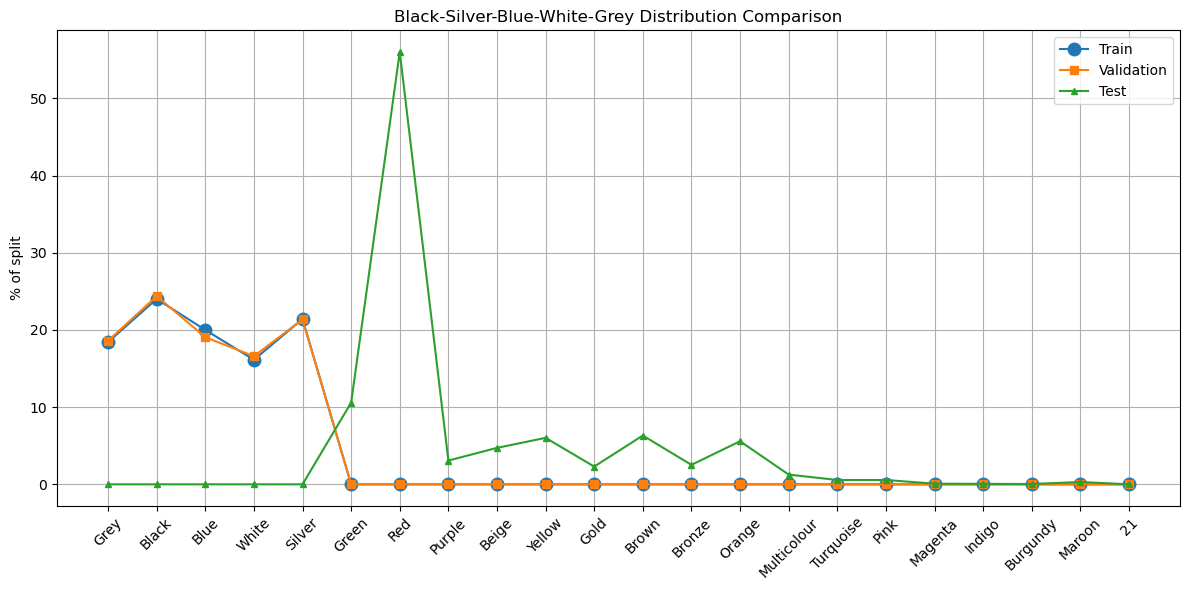

In [285]:
plot_compare_distribution(train_dist=train_multi_color_dist, val_dist=val_multi_color_dist, test_dist=test_multi_color_dist, feature=list(range(multi_color_lengths["Color"]+1)), feature_name="Black-Silver-Blue-White-Grey", xticks_map=xtick_multi_color_map)

### Train, Val: Black - Silver - Grey. Test: Everything else

In [286]:
train_b_s_g_df, val_b_s_g_df, test_b_s_g_df = create_shifted_splits(df=full_data_df, 
                                                                     split=[{"Color": "Black"},
                                                                            {"Color": "Silver"},
                                                                            {"Color": "Grey"}],
                                                                     split_cond="or",
                                                                     ratio=ratio,
                                                                     mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_b_s_g_df, val_b_s_g_df, test_b_s_g_df, cat_mapping = categorize(train_df=train_b_s_g_df,
                                                                       val_df=val_b_s_g_df,
                                                                       test_df=test_b_s_g_df,
                                                                       categorical_columns=cat_plus_gen_cols)

train_b_s_g_df, val_b_s_g_df, test_b_s_g_df, mean_b_s_g, std_b_s_g = normalize(train_df=train_b_s_g_df,
                                                         val_df=val_b_s_g_df,
                                                         test_df=test_b_s_g_df,
                                                         continuous_columns=continuous_columns)

train_b_s_g_df = reorder_df(df=train_b_s_g_df, new_order=reorder_columns)
val_b_s_g_df = reorder_df(df=val_b_s_g_df, new_order=reorder_columns)
test_b_s_g_df = reorder_df(df=test_b_s_g_df, new_order=reorder_columns)

display(train_b_s_g_df)
display(val_b_s_g_df)
display(test_b_s_g_df)

[29000, 5000, 5000]


286
286
Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Amount Classes: 286
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
13,0,0,0,0,0.016201,1.075294,0.956918,-1.190697,7.104967,0.076093,...,7.202082,5.356594,1.643351,1.558322,2.255956,1.721035,225,Bentley$$Bentayga$$2016$$Black$$10_3$$72$$imag...,0,10_3$$72
21,1,0,0,0,0.016201,1.075294,0.956918,-0.759821,6.101551,0.076093,...,7.202082,5.356594,2.077700,1.323986,2.255956,1.874955,315,Bentley$$Bentayga$$2016$$Silver$$10_3$$111$$im...,0,10_3$$111
33,0,0,0,0,-2.393116,2.041701,1.419236,-1.364253,13.801483,0.076093,...,7.202082,5.356594,1.846780,1.527077,2.379595,1.921375,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...,0,10_3$$20
34,1,0,0,1,-2.393116,3.008108,1.419236,-1.363285,11.982601,0.076093,...,7.202082,2.713303,2.017221,1.550511,2.008680,1.860296,135,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...,0,10_3$$21
36,0,0,0,0,0.016201,-1.340723,1.419236,-1.304682,8.939006,0.076093,...,7.202082,2.713303,1.769807,1.855148,2.275478,1.882285,90,Bentley$$Bentayga$$2018$$Black$$10_3$$23$$imag...,0,10_3$$23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176394,1,6,1,0,0.016201,-2.307130,-1.354671,1.056383,-0.601028,0.076093,...,-0.354942,-0.194317,0.114883,-0.816287,-1.062755,0.176946,45,Volvo$$V50$$2006$$Silver$$96_9$$385$$image_0.jpg,285,96_9$$385
176398,1,6,1,0,0.016201,-1.823927,-1.354671,0.679823,-0.504628,0.076093,...,-0.354942,-0.194317,0.015917,-0.363237,-0.704855,0.372400,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg,285,96_9$$450
176399,1,6,1,1,0.016201,0.592091,-1.354671,-0.348148,-0.474010,0.076093,...,-0.354942,0.070012,-0.061056,-0.675685,-1.088784,0.357741,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg,285,96_9$$454
176405,2,6,1,1,0.016201,0.108887,-1.816989,0.491762,-0.534336,0.076093,...,-0.267736,0.070012,-0.110539,-0.566328,-0.490115,0.321094,315,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg,285,96_9$$217


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
0,2,0,0,0,0.016201,-1.340723,0.956918,-1.058623,7.134675,0.076093,...,7.202082,5.356594,1.775305,1.628623,1.885041,1.777228,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,0,10_3$$1
23,2,0,0,0,0.016201,0.592091,0.956918,-0.824744,6.528988,0.076093,...,7.202082,5.356594,2.066704,1.534888,2.392609,1.757682,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$118$$imag...,0,10_3$$118
43,2,0,0,0,0.016201,-0.857520,1.419236,-1.341006,9.530142,0.076093,...,7.202082,2.713303,1.670842,1.675490,1.930592,1.777228,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$32$$image...,0,10_3$$32
70,1,0,0,0,0.016201,-1.340723,1.419236,-1.364617,9.712031,0.076093,...,7.202082,5.356594,1.637853,1.261496,2.457682,1.872512,225,Bentley$$Bentayga$$2018$$Silver$$10_3$$115$$im...,0,10_3$$115
84,2,0,0,0,-2.393116,2.041701,1.188077,-1.167934,7.981062,0.076093,...,7.202082,5.356594,2.099692,1.292741,2.464189,1.931148,225,Bentley$$Bentayga$$2017$$Grey$$10_3$$35$$image...,0,10_3$$35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176258,0,6,1,1,0.016201,1.075294,0.032283,2.020182,-0.549493,0.076093,...,-0.128584,-0.458646,-0.017071,-0.464783,-1.127828,0.374844,0,Volvo$$V50$$2012$$Black$$96_9$$55$$image_0.jpg,285,96_9$$55
176267,0,6,1,1,0.016201,1.075294,0.032283,0.979473,-0.413077,0.076093,...,-0.128584,-0.458646,0.015917,-0.597573,-0.711362,0.223367,0,Volvo$$V50$$2012$$Black$$96_9$$139$$image_1.jpg,285,96_9$$139
176324,1,6,1,1,0.016201,-1.340723,-0.430035,0.972087,-0.492502,0.076093,...,-0.248847,-0.458646,-0.132531,-0.277314,-0.841508,0.220923,135,Volvo$$V50$$2010$$Silver$$96_9$$392$$image_0.jpg,285,96_9$$392
176372,0,6,1,1,0.016201,0.108887,-1.354671,1.403883,-0.607395,0.076093,...,-0.354942,0.070012,0.037910,-0.394482,-1.004190,0.172060,45,Volvo$$V50$$2006$$Black$$96_9$$49$$image_0.jpg,285,96_9$$49


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
2,3,0,0,0,0.016201,0.108887,0.956918,-0.965028,7.007657,0.076093,...,7.202082,5.356594,1.736819,1.386475,2.353565,1.794330,225,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,0,10_3$$10
63,4,0,0,0,-2.393116,1.558498,1.419236,-1.362800,13.195189,0.076093,...,7.202082,5.356594,1.857776,1.808281,1.943607,1.777228,270,Bentley$$Bentayga$$2018$$White$$10_3$$97$$imag...,0,10_3$$97
106,3,0,0,1,0.016201,0.108887,1.188077,-1.100032,7.435397,0.076093,...,7.202082,2.713303,1.758811,1.816092,2.464189,1.911603,90,Bentley$$Bentayga$$2017$$Blue$$10_3$$117$$imag...,0,10_3$$117
113,3,1,0,0,0.016201,1.075294,1.419236,-1.328898,12.591623,-1.129089,...,7.485423,5.356594,0.989079,-1.159981,1.806954,0.997854,45,Bentley$$Continental$$2018$$Blue$$10_5$$264$$i...,1,10_5$$264
234,5,2,0,0,0.016201,0.592091,0.494600,-0.798687,4.707075,-1.129089,...,6.836886,5.356594,0.246837,-0.925644,1.982651,0.997854,90,Bentley$$Continental$$2014$$Red$$10_5$$28$$ima...,1,10_5$$28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176159,3,6,1,1,-2.393116,3.008108,-0.892353,2.477090,-0.534336,0.076093,...,-0.354942,0.598670,-0.231497,-0.730364,-0.913088,0.382173,270,Volvo$$V50$$2008$$Blue$$96_9$$52$$image_0.jpg,285,96_9$$52
176194,3,6,1,1,0.016201,1.075294,-0.892353,1.201679,-0.546765,0.076093,...,-0.354942,-0.458646,0.136875,-0.870966,-1.140843,0.313764,135,Volvo$$V50$$2008$$Blue$$96_9$$210$$image_10.jpg,285,96_9$$210
176234,3,6,1,1,0.016201,0.592091,-0.892353,1.177463,-0.510388,0.076093,...,-0.354942,0.070012,-0.182014,-0.745986,-0.717870,0.250242,315,Volvo$$V50$$2008$$Blue$$96_9$$413$$image_0.jpg,285,96_9$$413
176273,4,6,1,1,0.016201,-0.374316,0.032283,0.204632,-0.322740,0.076093,...,-0.128584,-0.458646,-0.149025,-0.839721,-0.874044,0.252685,270,Volvo$$V50$$2012$$White$$96_9$$181$$image_1.jpg,285,96_9$$181


In [287]:
b_s_g_lengths = get_lengths(df_list=[train_b_s_g_df, val_b_s_g_df, test_b_s_g_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [288]:
k = 0.1
low_train_b_s_g_df, high_train_b_s_g_df = create_splitted_train(train_df=train_b_s_g_df, low_data_split=k, nclasses=train_b_s_g_df["Genmodel_ID"].nunique())
display(low_train_b_s_g_df)
display(high_train_b_s_g_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
13,0,0,0,0,0.016201,1.075294,0.956918,-1.190697,7.104967,0.076093,...,7.202082,5.356594,1.643351,1.558322,2.255956,1.721035,225,Bentley$$Bentayga$$2016$$Black$$10_3$$72$$imag...,0,10_3$$72
56,2,0,0,1,0.016201,-1.823927,1.419236,-1.195710,9.257310,0.076093,...,7.202082,2.713303,1.879769,1.503644,2.457682,1.808989,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$78$$image...,0,10_3$$78
82,2,0,0,0,0.016201,-1.823927,1.188077,-1.239662,8.223579,-1.129089,...,7.202082,5.356594,2.050210,1.238062,2.132318,1.933591,0,Bentley$$Bentayga$$2017$$Grey$$10_3$$17$$image...,0,10_3$$17
109,0,1,0,0,-2.393116,1.075294,1.419236,-1.362800,10.163720,-1.129089,...,7.485423,2.713303,0.681186,-0.972512,2.477204,1.044274,90,Bentley$$Continental$$2018$$Black$$10_5$$20$$i...,1,10_5$$20
110,2,1,0,0,0.016201,1.075294,1.419236,-1.341006,10.771529,-1.129089,...,7.485423,5.356594,1.143025,-1.152170,1.748389,1.134672,90,Bentley$$Continental$$2018$$Grey$$10_5$$40$$im...,1,10_5$$40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176221,1,6,1,1,0.016201,0.592091,-0.892353,1.078008,-0.537368,0.076093,...,-0.354942,0.070012,-0.357953,-0.949078,-0.750406,0.303991,90,Volvo$$V50$$2008$$Silver$$96_9$$336$$image_0.jpg,285,96_9$$336
176352,1,6,0,0,0.016201,1.075294,-1.585830,0.402550,-0.516450,0.076093,...,-0.255143,0.598670,-0.105041,-0.738175,-1.069263,0.357741,315,Volvo$$V50$$2005$$Silver$$96_9$$338$$image_0.jpg,285,96_9$$338
176360,2,6,1,0,0.016201,0.592091,-1.585830,1.250111,-0.613154,0.076093,...,-0.255143,-0.194317,-0.253489,-0.488216,-0.821986,0.218480,45,Volvo$$V50$$2005$$Grey$$96_9$$393$$image_0.jpg,285,96_9$$393
176369,1,6,1,0,0.016201,-0.374316,-1.585830,2.557778,-0.668024,0.076093,...,-0.255143,-0.194317,0.103887,-0.449160,-0.581217,0.365071,315,Volvo$$V50$$2005$$Silver$$96_9$$502$$image_0.jpg,285,96_9$$502


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
21,1,0,0,0,0.016201,1.075294,0.956918,-0.759821,6.101551,0.076093,...,7.202082,5.356594,2.077700,1.323986,2.255956,1.874955,315,Bentley$$Bentayga$$2016$$Silver$$10_3$$111$$im...,0,10_3$$111
33,0,0,0,0,-2.393116,2.041701,1.419236,-1.364253,13.801483,0.076093,...,7.202082,5.356594,1.846780,1.527077,2.379595,1.921375,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...,0,10_3$$20
34,1,0,0,1,-2.393116,3.008108,1.419236,-1.363285,11.982601,0.076093,...,7.202082,2.713303,2.017221,1.550511,2.008680,1.860296,135,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...,0,10_3$$21
36,0,0,0,0,0.016201,-1.340723,1.419236,-1.304682,8.939006,0.076093,...,7.202082,2.713303,1.769807,1.855148,2.275478,1.882285,90,Bentley$$Bentayga$$2018$$Black$$10_3$$23$$imag...,0,10_3$$23
40,0,0,0,1,0.016201,-0.857520,1.419236,-1.328898,9.557426,0.076093,...,7.202082,2.713303,1.879769,1.777036,2.249449,1.879841,90,Bentley$$Bentayga$$2018$$Black$$10_3$$28$$imag...,0,10_3$$28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176394,1,6,1,0,0.016201,-2.307130,-1.354671,1.056383,-0.601028,0.076093,...,-0.354942,-0.194317,0.114883,-0.816287,-1.062755,0.176946,45,Volvo$$V50$$2006$$Silver$$96_9$$385$$image_0.jpg,285,96_9$$385
176398,1,6,1,0,0.016201,-1.823927,-1.354671,0.679823,-0.504628,0.076093,...,-0.354942,-0.194317,0.015917,-0.363237,-0.704855,0.372400,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg,285,96_9$$450
176399,1,6,1,1,0.016201,0.592091,-1.354671,-0.348148,-0.474010,0.076093,...,-0.354942,0.070012,-0.061056,-0.675685,-1.088784,0.357741,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg,285,96_9$$454
176405,2,6,1,1,0.016201,0.108887,-1.816989,0.491762,-0.534336,0.076093,...,-0.267736,0.070012,-0.110539,-0.566328,-0.490115,0.321094,315,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg,285,96_9$$217


In [289]:
print(get_num_of_classes(df_list=[low_train_b_s_g_df]))
print(get_num_of_classes(df_list=[high_train_b_s_g_df]))

286
286


In [290]:
b_s_g_dir = os.path.join(SHIFTED_DIR, "black-silver-grey")

In [291]:
save_lengths(lengths=b_s_g_lengths, file_name="tabular_lengths.pt", save_directory=b_s_g_dir)

In [292]:
save_dataset(df=train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_b_s_g_df, save_directory=b_s_g_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_b_s_g_df, save_directory=b_s_g_dir, split="test", k="", keep_cols=reorder_columns)

In [293]:
k = 0.01
low_train_b_s_g_df, high_train_b_s_g_df = create_splitted_train(train_df=train_b_s_g_df, low_data_split=k, nclasses=train_b_s_g_df["Genmodel_ID"].nunique())
display(low_train_b_s_g_df)
display(high_train_b_s_g_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
13,0,0,0,0,0.016201,1.075294,0.956918,-1.190697,7.104967,0.076093,...,7.202082,5.356594,1.643351,1.558322,2.255956,1.721035,225,Bentley$$Bentayga$$2016$$Black$$10_3$$72$$imag...,0,10_3$$72
109,0,1,0,0,-2.393116,1.075294,1.419236,-1.362800,10.163720,-1.129089,...,7.485423,2.713303,0.681186,-0.972512,2.477204,1.044274,90,Bentley$$Continental$$2018$$Black$$10_5$$20$$i...,1,10_5$$20
821,0,4,1,0,0.016201,-0.857520,-0.198876,0.063525,-0.625280,0.076093,...,-0.914699,-1.251633,-1.474065,-0.355426,-2.266602,-1.894869,0,Chevrolet$$Spark$$2011$$Black$$16_14$$27$$imag...,2,16_14$$27
1003,2,5,0,0,0.016201,-2.307130,0.725759,-0.929672,-0.286665,0.076093,...,-0.537540,-0.458646,-0.528394,0.620976,-0.789450,-0.866291,90,Citroen$$C3 Picasso$$2015$$Grey$$18_10$$78$$im...,3,18_10$$78
1453,0,4,1,1,0.016201,-0.857520,0.263441,-0.171153,-0.385855,0.076093,...,-0.478668,-0.458646,-0.363451,-0.691308,-0.522651,-0.177315,225,Citroen$$C4$$2013$$Black$$18_12$$2$$image_1.jpg,4,18_12$$2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174825,2,3,0,1,0.016201,0.108887,-0.198876,-0.269930,-0.188445,0.076093,...,0.023161,0.598670,0.879117,-0.496028,-0.340448,0.489673,225,Volvo$$S60$$2011$$Grey$$96_4$$70$$image_0.jpg,281,96_4$$70
175240,1,3,1,1,0.016201,0.592091,-0.892353,0.233037,-0.461884,0.076093,...,0.114145,0.070012,0.703178,-0.089844,1.403503,1.046718,0,Volvo$$S80$$2008$$Silver$$96_5$$37$$image_13.jpg,282,96_5$$37
175345,1,3,0,1,0.016201,-0.374316,1.419236,-1.364011,1.102657,0.076093,...,0.808016,0.070012,1.769807,-0.956889,0.895935,1.415638,225,Volvo$$S90$$2018$$Silver$$96_6$$19$$image_0.jpg,283,96_6$$19
175507,1,4,1,0,0.016201,-0.857520,0.263441,-0.614524,-0.141761,0.076093,...,-0.155974,-0.458646,0.032411,-0.628818,1.136705,-0.104019,0,Volvo$$V40$$2013$$Silver$$96_7$$335$$image_11.jpg,284,96_7$$335


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
21,1,0,0,0,0.016201,1.075294,0.956918,-0.759821,6.101551,0.076093,...,7.202082,5.356594,2.077700,1.323986,2.255956,1.874955,315,Bentley$$Bentayga$$2016$$Silver$$10_3$$111$$im...,0,10_3$$111
33,0,0,0,0,-2.393116,2.041701,1.419236,-1.364253,13.801483,0.076093,...,7.202082,5.356594,1.846780,1.527077,2.379595,1.921375,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...,0,10_3$$20
34,1,0,0,1,-2.393116,3.008108,1.419236,-1.363285,11.982601,0.076093,...,7.202082,2.713303,2.017221,1.550511,2.008680,1.860296,135,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...,0,10_3$$21
36,0,0,0,0,0.016201,-1.340723,1.419236,-1.304682,8.939006,0.076093,...,7.202082,2.713303,1.769807,1.855148,2.275478,1.882285,90,Bentley$$Bentayga$$2018$$Black$$10_3$$23$$imag...,0,10_3$$23
40,0,0,0,1,0.016201,-0.857520,1.419236,-1.328898,9.557426,0.076093,...,7.202082,2.713303,1.879769,1.777036,2.249449,1.879841,90,Bentley$$Bentayga$$2018$$Black$$10_3$$28$$imag...,0,10_3$$28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176394,1,6,1,0,0.016201,-2.307130,-1.354671,1.056383,-0.601028,0.076093,...,-0.354942,-0.194317,0.114883,-0.816287,-1.062755,0.176946,45,Volvo$$V50$$2006$$Silver$$96_9$$385$$image_0.jpg,285,96_9$$385
176398,1,6,1,0,0.016201,-1.823927,-1.354671,0.679823,-0.504628,0.076093,...,-0.354942,-0.194317,0.015917,-0.363237,-0.704855,0.372400,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg,285,96_9$$450
176399,1,6,1,1,0.016201,0.592091,-1.354671,-0.348148,-0.474010,0.076093,...,-0.354942,0.070012,-0.061056,-0.675685,-1.088784,0.357741,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg,285,96_9$$454
176405,2,6,1,1,0.016201,0.108887,-1.816989,0.491762,-0.534336,0.076093,...,-0.267736,0.070012,-0.110539,-0.566328,-0.490115,0.321094,315,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg,285,96_9$$217


In [294]:
print(get_num_of_classes(df_list=[train_b_s_g_df]))
print(get_num_of_classes(df_list=[val_b_s_g_df]))
print(get_num_of_classes(df_list=[test_b_s_g_df]))

286
286
286


In [295]:
print(get_num_of_classes(df_list=[low_train_b_s_g_df]))
print(get_num_of_classes(df_list=[high_train_b_s_g_df]))

286
286


In [296]:
save_dataset(df=low_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

In [297]:
train_b_s_g_dist = create_dist_dfs(df=train_b_s_g_df,
                                  cols=["Color"],
                                  fill_values=list(range(b_s_g_lengths["Color"] + 1)))
val_b_s_g_dist = create_dist_dfs(df=val_b_s_g_df,
                                cols=["Color"],
                                fill_values=list(range(b_s_g_lengths["Color"] + 1)))
test_b_s_g_dist = create_dist_dfs(df=test_b_s_g_df,
                                 cols=["Color"],
                                 fill_values=list(range(b_s_g_lengths["Color"] + 1)))


In [298]:
train_test_kl_b_s_g = calc_JS(first_dist=train_b_s_g_dist, second_dist=test_b_s_g_dist)
train_test_kl_b_s_g

0.8325546111576978

In [299]:
xtick_b_s_g_map = {v: k for k, v in cat_mapping["Color"].items()}

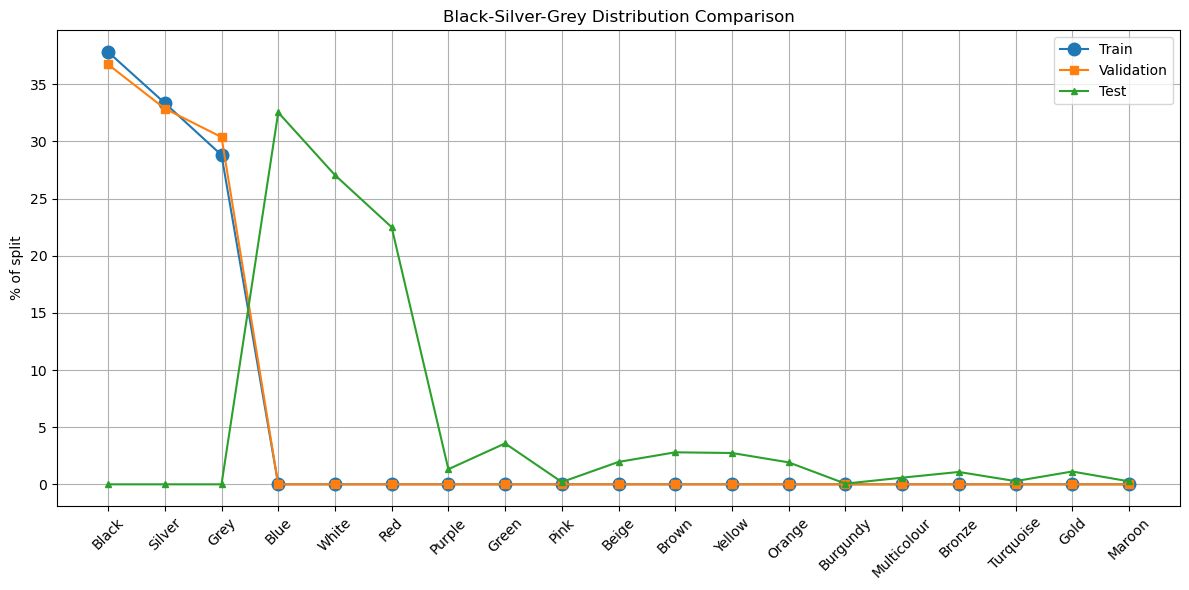

In [300]:
plot_compare_distribution(train_dist=train_b_s_g_dist, val_dist=val_b_s_g_dist, test_dist=test_b_s_g_dist, feature=list(range(b_s_g_lengths["Color"])), feature_name="Black-Silver-Grey", xticks_map=xtick_b_s_g_map)

### Train, Val: Black. Test: Everything else

In [301]:
train_black_df, val_black_df, test_black_df = create_shifted_splits(df=full_data_df, 
                                                                    split=[{"Color": "Black"}],
                                                                    split_cond="and",
                                                                    ratio=ratio,
                                                                    mode=1)
cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_black_df, val_black_df, test_black_df, cat_mapping = categorize(train_df=train_black_df,
                                                                            val_df=val_black_df,
                                                                            test_df=test_black_df,
                                                                            categorical_columns=cat_plus_gen_cols)

train_black_df, val_black_df, test_black_df, mean_year, std_year = normalize(train_df=train_black_df,
                                                               val_df=val_black_df,
                                                               test_df=test_black_df,
                                                               continuous_columns=continuous_columns)

train_black_df = reorder_df(df=train_black_df, new_order=reorder_columns)
val_black_df = reorder_df(df=val_black_df, new_order=reorder_columns)
test_black_df = reorder_df(df=test_black_df, new_order=reorder_columns)

display(train_black_df)
display(val_black_df)
display(test_black_df)

[29000, 5000, 5000]
Too little data.
286
286
Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(4992, 21)
Total Size: 38992
Amount Classes: 286
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
7,0,0,0,0,0.002985,1.083799,-1.257101,0.737795,-0.497205,0.121972,...,0.223757,1.233045,0.558335,1.747353,0.018634,0.928916,0,Jeep$$Grand Cherokee$$2007$$Black$$40_4$$84$$i...,0,40_4$$84
20,0,1,1,1,0.002985,-0.369956,-0.047548,-0.552870,-0.497506,0.121972,...,-0.807619,-0.945795,-0.589178,-0.100215,0.497496,-0.856746,45,Renault$$Clio$$2012$$Black$$75_2$$962$$image_0...,1,75_2$$962
21,0,2,0,1,0.002985,-1.339125,1.403916,-0.922575,1.131241,0.121972,...,-0.131633,0.022578,-0.112358,-1.211822,0.452802,0.227655,90,Audi$$A3$$2018$$Black$$7_3$$1609$$image_2.jpg,2,7_3$$1609
27,0,0,1,0,0.002985,1.083799,-0.289459,0.251355,-0.196490,0.121972,...,-0.110838,0.264672,-0.248592,1.379372,1.193442,0.320537,0,Honda$$CR-V$$2011$$Black$$34_3$$439$$image_0.jpg,3,34_3$$439
31,0,0,1,0,0.002985,-0.854540,0.678184,-0.459452,-0.044473,0.121972,...,-0.153600,0.022578,-0.033761,1.632359,1.333908,0.241587,90,Ford$$Kuga$$2015$$Black$$29_25$$395$$image_0.jpg,4,29_25$$395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0,0,1,0,0.002985,0.599214,0.920095,-0.879887,-0.225445,0.121972,...,-0.490421,-0.582655,-0.845928,1.111053,1.046591,-0.285520,0,Ford$$EcoSport$$2016$$Black$$29_4$$430$$image_...,165,29_4$$430
33996,0,3,0,0,0.002985,-0.369956,0.436273,-0.542049,-0.045077,2.493527,...,-0.199876,-0.461609,1.066595,0.612747,-0.517691,0.457538,90,Citroen$$Grand C4 Picasso$$2014$$Black$$18_24$...,51,18_24$$1161
33997,0,1,1,1,0.002985,-0.854540,-0.289459,0.069316,-0.629616,-1.063806,...,-0.859753,-0.945795,-1.956763,-0.199876,-1.954276,-2.089758,0,Fiat$$Panda$$2011$$Black$$28_18$$52$$image_4.jpg,105,28_18$$52
33998,0,0,1,0,0.002985,0.599214,-0.289459,0.610347,-0.485441,0.121972,...,-0.423643,-0.582655,0.102474,0.428757,-1.060401,-0.027772,45,Nissan$$Qashqai$$2011$$Black$$64_33$$1621$$ima...,15,64_33$$1621


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
0,0,1,0,1,0.002985,1.083799,-0.047548,-0.255303,-0.527065,-1.063806,...,-0.848038,-1.187889,-1.851967,-0.376200,-0.370840,-2.270878,135,Peugeot$$107$$2012$$Black$$69_3$$768$$image_0.jpg,33,69_3$$768
1,0,0,0,0,0.002985,-1.339125,0.194363,0.310976,1.372597,0.121972,...,2.707624,1.233045,1.139952,2.337654,1.889388,1.442090,90,Land Rover$$Range Rover$$2013$$Black$$47_13$$2...,48,47_13$$283
2,0,1,1,1,0.002985,-1.823710,0.678184,-0.558605,-0.166026,0.121972,...,-0.278956,-0.461609,-0.384827,-0.038885,-0.351685,-0.248367,225,Citroen$$DS4$$2015$$Black$$21_3$$436$$image_1.jpg,26,21_3$$436
3,0,1,1,1,0.002985,0.114629,0.678184,-0.917795,-0.438389,-1.063806,...,-0.760171,-1.187889,-0.877367,0.252433,-1.705268,-1.913282,225,Renault$$Twingo$$2015$$Black$$75_18$$92$$image...,80,75_18$$92
4,0,3,1,0,0.002985,-0.369956,0.194363,-0.153481,-0.408408,0.121972,...,-0.284228,-0.582655,-0.007562,0.850401,1.008282,-0.060280,225,Renault$$Scenic$$2013$$Black$$75_14$$924$$imag...,173,75_14$$924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33968,0,1,1,1,0.002985,1.083799,-1.740922,0.336837,-0.620567,0.121972,...,-0.835619,0.022578,-0.730653,-0.636853,-0.115447,-1.035544,45,Ford$$Fiesta$$2005$$Black$$29_13$$382$$image_0...,19,29_13$$382
33973,0,0,0,0,0.002985,-0.369956,0.194363,-0.047511,1.517736,0.121972,...,2.707624,2.927699,1.113753,2.460314,2.291632,1.456023,225,Land Rover$$Range Rover$$2013$$Black$$47_13$$1...,48,47_13$$1900
33976,0,1,1,0,0.002985,1.083799,0.436273,-0.147097,-0.225445,0.121972,...,-0.333726,-0.461609,0.123433,-0.368534,-0.734775,-0.378402,90,Volkswagen$$Golf$$2014$$Black$$95_15$$491$$ima...,42,95_15$$491
33978,0,3,1,0,0.002985,1.083799,1.162005,-0.770743,-0.086760,0.121972,...,-0.200462,-0.582655,1.260467,0.934730,1.091285,-0.057958,90,Ford$$C-Max$$2017$$Black$$29_2$$364$$image_0.jpg,126,29_2$$364


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
0,1,0,0,1,0.002985,-1.339125,0.920095,-0.766379,7.042989,0.121972,...,6.641697,4.864446,1.684890,1.586361,1.819155,1.699839,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,240,10_3$$1
75,2,0,0,1,0.002985,1.083799,1.403916,-0.994532,10.828619,0.121972,...,6.641697,2.443512,1.684890,1.448369,2.093702,1.660364,90,Bentley$$Bentayga$$2018$$Silver$$10_3$$127$$im...,240,10_3$$127
98,1,0,0,1,0.002985,-2.308295,1.162005,-0.812168,8.850294,0.121972,...,6.641697,4.864446,1.705849,1.249046,1.972391,1.827552,225,Bentley$$Bentayga$$2017$$Grey$$10_3$$90$$image...,240,10_3$$90
108,1,5,0,1,0.002985,1.083799,1.403916,-0.946019,9.456550,-1.063806,...,6.905296,2.443512,0.699810,-0.912838,2.151166,0.898729,135,Bentley$$Continental$$2018$$Grey$$10_5$$1$$ima...,190,10_5$$1
163,3,5,0,1,0.002985,-0.369956,-1.015190,-0.266376,2.519295,-1.063806,...,5.745459,4.864446,0.464019,-1.503140,0.063328,1.054307,0,Bentley$$Continental$$2008$$Blue$$10_5$$61$$im...,190,10_5$$61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176234,3,4,1,0,0.002985,0.599214,-1.015190,0.898897,-0.563561,0.121972,...,-0.388789,0.022578,-0.180475,-0.744180,-0.734775,0.248553,315,Volvo$$V50$$2008$$Blue$$96_9$$413$$image_0.jpg,211,96_9$$413
176239,1,4,1,0,0.002985,0.114629,-1.015190,0.664450,-0.557830,0.121972,...,-0.388789,0.022578,-0.332429,-0.529525,-0.734775,0.202112,0,Volvo$$V50$$2008$$Grey$$96_9$$444$$image_0.jpg,211,96_9$$444
176339,2,4,1,1,0.002985,-0.369956,-1.740922,0.502140,-0.587449,0.121972,...,-0.295944,-0.219515,-0.274791,-0.567856,-0.919935,0.255519,0,Volvo$$V50$$2005$$Silver$$96_9$$153$$image_0.jpg,211,96_9$$153
176399,2,4,1,0,0.002985,0.599214,-1.499012,-0.237269,-0.527367,0.121972,...,-0.388789,0.022578,-0.065199,-0.675184,-1.098710,0.350724,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg,211,96_9$$454


In [302]:
print(get_num_of_classes(df_list=[train_black_df]))
print(get_num_of_classes(df_list=[val_black_df]))
print(get_num_of_classes(df_list=[test_black_df]))

285
286
285


In [303]:
black_lengths = get_lengths(df_list=[train_black_df, val_black_df, test_black_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [304]:
k = 0.1
low_train_black_df, high_train_black_df = create_splitted_train(train_df=train_black_df, low_data_split=k, nclasses=train_black_df["Genmodel_ID"].nunique())
display(low_train_black_df)
display(high_train_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
7,0,0,0,0,0.002985,1.083799,-1.257101,0.737795,-0.497205,0.121972,...,0.223757,1.233045,0.558335,1.747353,0.018634,0.928916,0,Jeep$$Grand Cherokee$$2007$$Black$$40_4$$84$$i...,0,40_4$$84
20,0,1,1,1,0.002985,-0.369956,-0.047548,-0.552870,-0.497506,0.121972,...,-0.807619,-0.945795,-0.589178,-0.100215,0.497496,-0.856746,45,Renault$$Clio$$2012$$Black$$75_2$$962$$image_0...,1,75_2$$962
21,0,2,0,1,0.002985,-1.339125,1.403916,-0.922575,1.131241,0.121972,...,-0.131633,0.022578,-0.112358,-1.211822,0.452802,0.227655,90,Audi$$A3$$2018$$Black$$7_3$$1609$$image_2.jpg,2,7_3$$1609
27,0,0,1,0,0.002985,1.083799,-0.289459,0.251355,-0.196490,0.121972,...,-0.110838,0.264672,-0.248592,1.379372,1.193442,0.320537,0,Honda$$CR-V$$2011$$Black$$34_3$$439$$image_0.jpg,3,34_3$$439
31,0,0,1,0,0.002985,-0.854540,0.678184,-0.459452,-0.044473,0.121972,...,-0.153600,0.022578,-0.033761,1.632359,1.333908,0.241587,90,Ford$$Kuga$$2015$$Black$$29_25$$395$$image_0.jpg,4,29_25$$395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33930,0,1,1,1,0.002985,0.114629,1.403916,-0.960447,0.558163,0.121972,...,-0.131633,-1.187889,-0.211914,-0.629187,0.650732,-0.095111,225,Audi$$A3$$2018$$Black$$7_3$$1841$$image_1.jpg,2,7_3$$1841
33934,0,1,1,1,0.002985,-0.854540,1.403916,-0.924162,0.166057,0.121972,...,-0.553392,-1.187889,-0.631097,-0.115547,0.599653,-1.021612,225,Ford$$Fiesta$$2018$$Black$$29_13$$1564$$image_...,19,29_13$$1564
33957,0,4,0,0,0.002985,-0.854540,0.920095,-0.505530,0.769598,0.121972,...,1.407494,0.143625,1.150432,-1.073829,0.969973,1.330632,180,Mercedes-Benz$$CLS$$2016$$Black$$59_19$$11$$im...,152,59_19$$11
33959,0,1,1,1,0.002985,1.083799,-0.047548,-0.225835,-0.496903,0.121972,...,-0.678162,-0.703702,-0.950724,-0.491194,-0.951859,-1.005358,225,Citroen$$C3$$2012$$Black$$18_8$$356$$image_1.jpg,107,18_8$$356


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
85,0,1,1,0,0.002985,1.083799,-1.015190,1.434517,-0.623583,0.121972,...,-0.447952,-0.098469,-0.652056,-1.012499,-0.779469,-0.250689,180,Audi$$A3$$2008$$Black$$7_3$$1413$$image_0.jpg,2,7_3$$1413
86,0,1,0,0,0.002985,-0.369956,-0.047548,0.484106,-0.497024,0.121972,...,-0.452053,-0.461609,-0.248592,-0.337869,-0.753929,-0.199604,135,SEAT$$Leon$$2012$$Black$$79_10$$524$$image_12.jpg,5,79_10$$524
88,0,1,0,0,0.002985,-1.339125,-1.499012,0.574837,-0.617853,0.121972,...,-0.328630,0.022578,0.416861,0.106774,0.274027,-0.287842,180,Mercedes-Benz$$B Class$$2006$$Black$$59_11$$60...,14,59_11$$606
91,0,1,1,1,0.002985,0.599214,-0.531369,0.267694,-0.617853,0.121972,...,-0.824899,-0.945795,-1.406585,-0.268872,-1.494569,-1.574261,0,Nissan$$Micra$$2010$$Black$$64_17$$979$$image_...,12,64_17$$979
98,0,1,1,1,0.002985,0.114629,1.162005,-0.748272,-0.235700,0.121972,...,-0.848038,-1.187889,-0.536780,-0.422198,-1.309409,-1.016968,225,Nissan$$Micra$$2017$$Black$$64_17$$1723$$image...,12,64_17$$1723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0,0,1,0,0.002985,0.599214,0.920095,-0.879887,-0.225445,0.121972,...,-0.490421,-0.582655,-0.845928,1.111053,1.046591,-0.285520,0,Ford$$EcoSport$$2016$$Black$$29_4$$430$$image_...,165,29_4$$430
33996,0,3,0,0,0.002985,-0.369956,0.436273,-0.542049,-0.045077,2.493527,...,-0.199876,-0.461609,1.066595,0.612747,-0.517691,0.457538,90,Citroen$$Grand C4 Picasso$$2014$$Black$$18_24$...,51,18_24$$1161
33997,0,1,1,1,0.002985,-0.854540,-0.289459,0.069316,-0.629616,-1.063806,...,-0.859753,-0.945795,-1.956763,-0.199876,-1.954276,-2.089758,0,Fiat$$Panda$$2011$$Black$$28_18$$52$$image_4.jpg,105,28_18$$52
33998,0,0,1,0,0.002985,0.599214,-0.289459,0.610347,-0.485441,0.121972,...,-0.423643,-0.582655,0.102474,0.428757,-1.060401,-0.027772,45,Nissan$$Qashqai$$2011$$Black$$64_33$$1621$$ima...,15,64_33$$1621


In [305]:
black_dir = os.path.join(SHIFTED_DIR, "black")

In [306]:
save_lengths(lengths=black_lengths, file_name="tabular_lengths.pt", save_directory=black_dir)

In [307]:
save_dataset(df=train_black_df, save_directory=black_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_black_df, save_directory=black_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_black_df, save_directory=black_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_black_df, save_directory=black_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_black_df, save_directory=black_dir, split="test", k="", keep_cols=reorder_columns)

In [308]:
k = 0.01
low_train_black_df, high_train_black_df = create_splitted_train(train_df=train_black_df, low_data_split=k, nclasses=train_black_df["Genmodel_ID"].nunique())
display(low_train_black_df)
display(high_train_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
7,0,0,0,0,0.002985,1.083799,-1.257101,0.737795,-0.497205,0.121972,...,0.223757,1.233045,0.558335,1.747353,0.018634,0.928916,0,Jeep$$Grand Cherokee$$2007$$Black$$40_4$$84$$i...,0,40_4$$84
20,0,1,1,1,0.002985,-0.369956,-0.047548,-0.552870,-0.497506,0.121972,...,-0.807619,-0.945795,-0.589178,-0.100215,0.497496,-0.856746,45,Renault$$Clio$$2012$$Black$$75_2$$962$$image_0...,1,75_2$$962
21,0,2,0,1,0.002985,-1.339125,1.403916,-0.922575,1.131241,0.121972,...,-0.131633,0.022578,-0.112358,-1.211822,0.452802,0.227655,90,Audi$$A3$$2018$$Black$$7_3$$1609$$image_2.jpg,2,7_3$$1609
27,0,0,1,0,0.002985,1.083799,-0.289459,0.251355,-0.196490,0.121972,...,-0.110838,0.264672,-0.248592,1.379372,1.193442,0.320537,0,Honda$$CR-V$$2011$$Black$$34_3$$439$$image_0.jpg,3,34_3$$439
31,0,0,1,0,0.002985,-0.854540,0.678184,-0.459452,-0.044473,0.121972,...,-0.153600,0.022578,-0.033761,1.632359,1.333908,0.241587,90,Ford$$Kuga$$2015$$Black$$29_25$$395$$image_0.jpg,4,29_25$$395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14558,0,0,1,1,0.002985,0.599214,1.403916,-0.994532,0.223667,0.121972,...,-0.279835,0.022578,-0.227633,0.198769,-0.798623,-0.294808,225,Mazda$$CX-3$$2018$$Black$$57_6$$537$$image_1.jpg,148,57_6$$537
23071,0,0,0,0,-2.401459,2.052969,-0.531369,0.491320,0.286705,0.121972,...,2.327104,1.959325,1.103273,2.636638,1.640380,1.456023,270,Land Rover$$Range Rover$$2010$$Black$$47_13$$1...,48,47_13$$1206
25983,0,2,0,0,0.002985,0.599214,-0.773280,0.449823,-0.134959,0.121972,...,1.709168,1.233045,1.999277,-0.636853,-0.109062,1.651075,0,BMW$$7 Series$$2009$$Black$$8_14$$105$$image_0...,178,8_14$$105
27720,0,1,1,1,0.002985,-2.308295,-1.015190,-0.256854,-0.648437,0.121972,...,-0.722389,-0.945795,-0.678255,0.352094,0.574114,-0.847458,270,Renault$$Grand Modus$$2008$$Black$$75_6$$57$$i...,284,75_6$$57


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
85,0,1,1,0,0.002985,1.083799,-1.015190,1.434517,-0.623583,0.121972,...,-0.447952,-0.098469,-0.652056,-1.012499,-0.779469,-0.250689,180,Audi$$A3$$2008$$Black$$7_3$$1413$$image_0.jpg,2,7_3$$1413
86,0,1,0,0,0.002985,-0.369956,-0.047548,0.484106,-0.497024,0.121972,...,-0.452053,-0.461609,-0.248592,-0.337869,-0.753929,-0.199604,135,SEAT$$Leon$$2012$$Black$$79_10$$524$$image_12.jpg,5,79_10$$524
88,0,1,0,0,0.002985,-1.339125,-1.499012,0.574837,-0.617853,0.121972,...,-0.328630,0.022578,0.416861,0.106774,0.274027,-0.287842,180,Mercedes-Benz$$B Class$$2006$$Black$$59_11$$60...,14,59_11$$606
91,0,1,1,1,0.002985,0.599214,-0.531369,0.267694,-0.617853,0.121972,...,-0.824899,-0.945795,-1.406585,-0.268872,-1.494569,-1.574261,0,Nissan$$Micra$$2010$$Black$$64_17$$979$$image_...,12,64_17$$979
98,0,1,1,1,0.002985,0.114629,1.162005,-0.748272,-0.235700,0.121972,...,-0.848038,-1.187889,-0.536780,-0.422198,-1.309409,-1.016968,225,Nissan$$Micra$$2017$$Black$$64_17$$1723$$image...,12,64_17$$1723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0,0,1,0,0.002985,0.599214,0.920095,-0.879887,-0.225445,0.121972,...,-0.490421,-0.582655,-0.845928,1.111053,1.046591,-0.285520,0,Ford$$EcoSport$$2016$$Black$$29_4$$430$$image_...,165,29_4$$430
33996,0,3,0,0,0.002985,-0.369956,0.436273,-0.542049,-0.045077,2.493527,...,-0.199876,-0.461609,1.066595,0.612747,-0.517691,0.457538,90,Citroen$$Grand C4 Picasso$$2014$$Black$$18_24$...,51,18_24$$1161
33997,0,1,1,1,0.002985,-0.854540,-0.289459,0.069316,-0.629616,-1.063806,...,-0.859753,-0.945795,-1.956763,-0.199876,-1.954276,-2.089758,0,Fiat$$Panda$$2011$$Black$$28_18$$52$$image_4.jpg,105,28_18$$52
33998,0,0,1,0,0.002985,0.599214,-0.289459,0.610347,-0.485441,0.121972,...,-0.423643,-0.582655,0.102474,0.428757,-1.060401,-0.027772,45,Nissan$$Qashqai$$2011$$Black$$64_33$$1621$$ima...,15,64_33$$1621


In [309]:
get_num_of_classes(df_list=[low_train_black_df])

285

In [310]:
save_dataset(df=low_train_black_df, save_directory=black_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_black_df, save_directory=black_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

In [311]:
train_black_dist = create_dist_dfs(df=train_black_df,
                                  cols=["Color"],
                                  fill_values=list(range(black_lengths["Color"] + 1)))
val_black_dist = create_dist_dfs(df=val_black_df,
                                cols=["Color"],
                                fill_values=list(range(black_lengths["Color"] + 1)))
test_black_dist = create_dist_dfs(df=test_black_df,
                                 cols=["Color"],
                                 fill_values=list(range(black_lengths["Color"] + 1)))


In [312]:
xtick_black_map = {v: k for k, v in cat_mapping["Color"].items()}

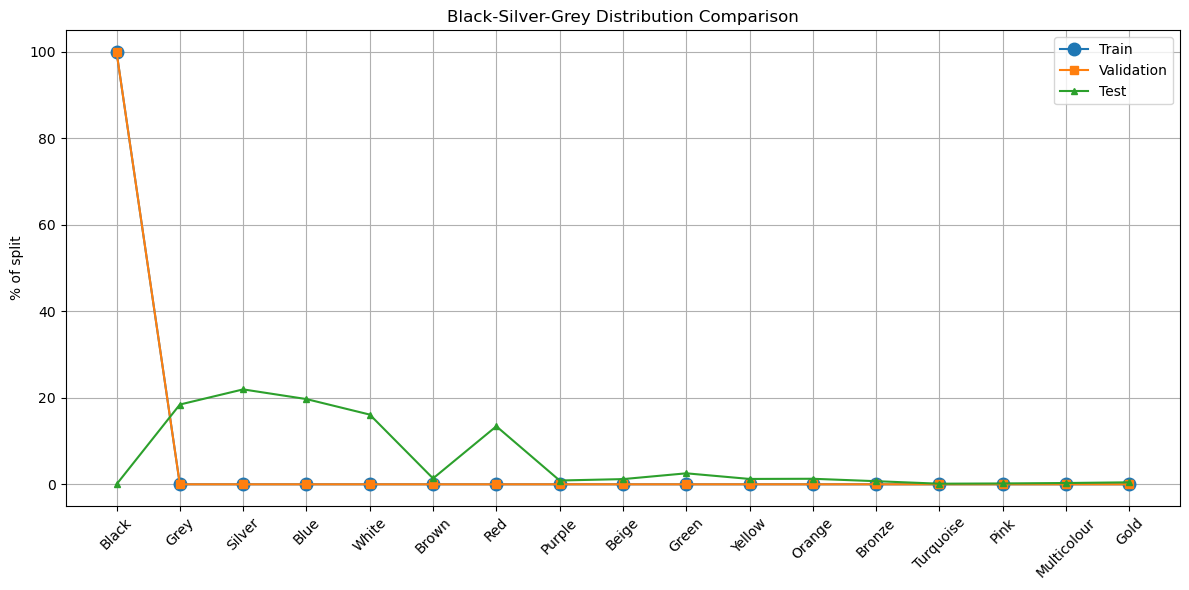

In [313]:
plot_compare_distribution(train_dist=train_black_dist, val_dist=val_black_dist, test_dist=test_black_dist, feature=list(range(black_lengths["Color"])), feature_name="Black-Silver-Grey", xticks_map=xtick_black_map)

## Non-Image-based Features

### Advertisement Year

In [315]:
train_month_df, val_month_df, test_month_df = create_shifted_splits(df=full_data_df, 
                                                                           split=[{"Adv_year": (">=", 2018)}],
                                                                           split_cond="and",
                                                                           ratio=ratio,
                                                                           mode=1)
cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_month_df, val_month_df, test_month_df, cat_mapping = categorize(train_df=train_month_df,
                                                                            val_df=val_month_df,
                                                                            test_df=test_month_df,
                                                                            categorical_columns=cat_plus_gen_cols)

train_month_df, val_month_df, test_month_df, mean_year, std_year = normalize(train_df=train_month_df,
                                                               val_df=val_month_df,
                                                               test_df=test_month_df,
                                                               continuous_columns=continuous_columns)

train_month_df = reorder_df(df=train_month_df, new_order=reorder_columns)
val_month_df = reorder_df(df=val_month_df, new_order=reorder_columns)
test_month_df = reorder_df(df=test_month_df, new_order=reorder_columns)

display(train_month_df)
display(val_month_df)
display(test_month_df)

[29000, 5000, 5000]
286
281
Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Amount Classes: 286
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
4,0,0,0,0,-0.11968,0.221479,0.882953,-1.146216,8.637414,0.124921,...,7.871571,5.844186,2.068782,1.592215,2.244996,1.982645,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,10_3$$12
17,0,0,0,0,-0.11968,1.287786,0.882953,-0.796841,7.792562,0.124921,...,7.871571,5.844186,1.800109,1.946718,2.451014,2.043086,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$93$$image...,0,10_3$$93
31,1,0,0,1,-0.11968,1.287786,1.353814,-1.226052,8.179597,0.124921,...,7.871571,3.029608,1.800109,1.930230,1.845837,1.958469,90,Bentley$$Bentayga$$2018$$White$$10_3$$18$$imag...,0,10_3$$18
32,2,0,0,1,-0.11968,0.754632,1.353814,-1.295877,11.884022,0.124921,...,7.871571,3.029608,2.124756,1.328399,2.431699,1.902863,90,Bentley$$Bentayga$$2018$$Black$$10_3$$19$$imag...,0,10_3$$19
37,2,0,0,0,-0.11968,-1.377980,1.353814,-1.246323,9.610844,0.124921,...,7.871571,3.029608,2.107964,1.790077,2.405947,1.844840,90,Bentley$$Bentayga$$2018$$Black$$10_3$$25$$imag...,0,10_3$$25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176386,3,6,2,1,-0.11968,-0.844827,-1.471351,1.181280,-0.583939,0.124921,...,-0.273031,0.215031,-0.231733,-0.740908,-0.561991,0.532058,315,Volvo$$V50$$2006$$Blue$$96_9$$272$$image_0.jpg,285,96_9$$272
176393,5,6,2,1,-0.11968,-0.311674,-1.471351,1.143490,-0.610175,0.124921,...,-0.273031,0.215031,0.008954,-1.078922,-0.819513,0.328976,45,Volvo$$V50$$2006$$Green$$96_9$$381$$image_0.jpg,285,96_9$$381
176403,3,6,0,1,-0.11968,-0.311674,-1.471351,1.506629,-0.567640,0.124921,...,-0.273031,0.777947,-0.035825,-0.312207,-0.478297,0.336229,180,Volvo$$V50$$2006$$Blue$$96_9$$516$$image_0.jpg,285,96_9$$516
176404,5,6,2,0,-0.11968,-0.311674,-1.942212,0.530582,-0.587121,0.124921,...,-0.179044,-0.066426,-0.108591,-0.262741,-1.006216,0.416011,0,Volvo$$V50$$2004$$Green$$96_9$$45$$image_0.jpg,285,96_9$$45


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
0,0,0,0,0,-0.11968,-1.377980,0.882953,-0.979512,7.662685,0.124921,...,7.871571,5.844186,1.928848,1.748856,1.910218,1.907698,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,0,10_3$$1
43,0,0,0,0,-0.11968,-0.844827,1.353814,-1.271350,10.228411,0.124921,...,7.871571,3.029608,1.822499,1.798322,1.955284,1.907698,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$32$$image...,0,10_3$$32
56,0,0,0,1,-0.11968,-1.911134,1.353814,-1.121189,9.936187,0.124921,...,7.871571,3.029608,2.035198,1.616948,2.476766,1.939128,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$78$$image...,0,10_3$$78
77,0,0,0,0,-0.11968,0.221479,1.353814,-1.294876,13.829259,0.124921,...,7.871571,3.029608,1.822499,1.608704,2.290062,1.931875,90,Bentley$$Bentayga$$2018$$Grey$$10_3$$129$$imag...,0,10_3$$129
108,0,2,0,0,-0.11968,1.287786,1.353814,-1.228805,10.260880,-1.142651,...,8.176943,3.029608,0.876545,-0.938770,2.244996,1.073611,135,Bentley$$Continental$$2018$$Grey$$10_5$$1$$ima...,1,10_5$$1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176141,0,6,2,1,-0.11968,-1.377980,-0.294199,0.042559,-0.291715,0.124921,...,-0.148507,0.215031,-0.035825,-0.815106,-0.587743,0.408758,0,Volvo$$V50$$2011$$Grey$$96_9$$491$$image_0.jpg,285,96_9$$491
176146,6,6,2,0,-0.11968,0.221479,-1.000490,0.983543,-0.486596,0.124921,...,-0.273031,-0.066426,-0.186954,-0.386405,-1.077035,0.490958,225,Volvo$$V50$$2008$$Red$$96_9$$4$$image_1.jpg,285,96_9$$4
176297,4,6,2,1,-0.11968,-0.311674,-0.058768,0.530582,-0.357303,0.124921,...,-0.029073,-0.347884,0.042538,-0.650221,-0.806637,0.437770,0,Volvo$$V50$$2012$$Silver$$96_9$$436$$image_0.jpg,285,96_9$$436
176319,2,6,2,1,-0.11968,0.754632,-0.529629,1.106200,-0.454322,0.124921,...,-0.158686,-0.347884,0.115304,-0.559535,-0.574867,0.348317,0,Volvo$$V50$$2010$$Black$$96_9$$249$$image_0.jpg,285,96_9$$249


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
6,0,0,0,0,-3.007137,1.820939,0.882953,-0.813785,7.338316,0.124921,...,7.871571,5.844186,1.956835,2.020916,1.916656,1.861763,135,Bentley$$Bentayga$$2016$$Grey$$10_3$$41$$image...,0,10_3$$41
18,2,0,0,0,-3.007137,2.354092,0.882953,-0.929634,8.182194,0.124921,...,7.871571,5.844186,2.057588,2.029161,2.277186,1.958469,315,Bentley$$Bentayga$$2016$$Black$$10_3$$94$$imag...,0,10_3$$94
34,4,0,0,1,-3.007137,3.420398,1.353814,-1.294375,12.855180,0.124921,...,7.871571,3.029608,2.175132,1.666414,2.032541,1.989898,135,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...,0,10_3$$21
48,2,0,0,1,-3.007137,1.287786,1.353814,-1.293874,12.855180,0.124921,...,7.871571,3.029608,1.928848,1.682902,2.187054,1.936710,225,Bentley$$Bentayga$$2018$$Black$$10_3$$44$$imag...,0,10_3$$44
55,2,0,0,0,-3.007137,1.287786,1.353814,-1.293874,14.153953,0.124921,...,7.871571,5.844186,2.169535,1.435574,2.058293,1.951216,45,Bentley$$Bentayga$$2018$$Black$$10_3$$76$$imag...,0,10_3$$76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176224,6,6,2,1,-3.007137,1.820939,-1.000490,1.819465,-0.583874,0.124921,...,-0.273031,0.215031,-0.024631,-0.477092,-0.600619,0.573158,270,Volvo$$V50$$2008$$Red$$96_9$$349$$image_0.jpg,285,96_9$$349
176289,0,6,2,1,-3.007137,3.420398,-0.058768,0.986346,-0.389708,0.124921,...,-0.029073,0.215031,-0.175759,-0.485336,-0.922522,0.493376,225,Volvo$$V50$$2012$$Grey$$96_9$$334$$image_10.jpg,285,96_9$$334
176341,0,6,2,1,-3.007137,2.887245,-1.706781,1.206307,-0.668619,0.124921,...,-0.165472,0.215031,-0.192551,-0.551290,-0.941836,0.476452,315,Volvo$$V50$$2005$$Grey$$96_9$$177$$image_0.jpg,285,96_9$$177
176385,4,6,2,0,-3.007137,2.354092,-1.471351,1.181280,-0.583874,0.124921,...,-0.273031,0.215031,0.104109,-0.411138,-0.716504,0.493376,45,Volvo$$V50$$2006$$Silver$$96_9$$241$$image_0.jpg,285,96_9$$241


In [316]:
print(get_num_of_classes(df_list=[train_month_df]))
print(get_num_of_classes(df_list=[val_month_df]))
print(get_num_of_classes(df_list=[test_month_df]))

286
286
281


In [317]:
month_lengths = get_lengths(df_list=[train_month_df, val_month_df, test_month_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [318]:
k = 0.1
low_train_month_df, high_train_month_df = create_splitted_train(train_df=train_month_df, low_data_split=k, nclasses=train_month_df["Genmodel_ID"].nunique())
display(low_train_month_df)
display(high_train_month_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
4,0,0,0,0,-0.11968,0.221479,0.882953,-1.146216,8.637414,0.124921,...,7.871571,5.844186,2.068782,1.592215,2.244996,1.982645,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,10_3$$12
54,2,0,0,1,-0.11968,-1.911134,1.353814,-1.283864,10.909293,0.124921,...,7.871571,3.029608,1.839291,1.814810,2.309377,1.941545,135,Bentley$$Bentayga$$2018$$Black$$10_3$$64$$imag...,0,10_3$$64
111,2,1,0,0,-0.11968,1.287786,1.353814,-1.270099,12.565878,-1.142651,...,8.176943,5.844186,1.273957,-0.856328,1.935970,1.298452,90,Bentley$$Continental$$2018$$Black$$10_5$$122$$...,1,10_5$$122
232,1,1,0,0,-0.11968,-1.911134,0.412093,-0.899777,4.607971,-1.142651,...,7.477981,5.844186,0.451145,-1.548845,2.064731,1.076028,90,Bentley$$Continental$$2014$$White$$10_5$$4$$im...,1,10_5$$4
309,0,1,0,0,-0.11968,-0.844827,-0.294199,-0.559662,3.049443,-1.142651,...,7.057247,5.844186,0.417561,-0.848083,0.107566,1.235593,90,Bentley$$Continental$$2011$$Grey$$10_5$$78$$im...,1,10_5$$78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176124,0,6,0,1,-0.11968,1.287786,-0.294199,-0.665075,-0.162423,0.124921,...,-0.148507,0.215031,0.160082,-0.790374,-0.793761,0.551399,0,Volvo$$V50$$2011$$Grey$$96_9$$333$$image_22.jpg,285,96_9$$333
176185,0,6,2,1,-0.11968,-0.311674,-1.000490,1.716154,-0.616344,0.124921,...,-0.273031,0.215031,0.160082,-0.534802,-0.916084,0.486123,0,Volvo$$V50$$2008$$Grey$$96_9$$168$$image_1.jpg,285,96_9$$168
176248,4,6,2,1,-0.11968,0.221479,-1.000490,1.251856,-0.538742,0.124921,...,-0.273031,0.215031,-0.153370,-0.963503,-0.600619,0.428099,0,Volvo$$V50$$2008$$Silver$$96_9$$487$$image_0.jpg,285,96_9$$487
176279,3,6,2,1,-0.11968,1.287786,-0.058768,0.305341,-0.259506,0.124921,...,-0.029073,-0.347884,0.260835,-0.716175,-0.542677,0.406341,270,Volvo$$V50$$2012$$Blue$$96_9$$236$$image_0.jpg,285,96_9$$236


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
17,0,0,0,0,-0.11968,1.287786,0.882953,-0.796841,7.792562,0.124921,...,7.871571,5.844186,1.800109,1.946718,2.451014,2.043086,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$93$$image...,0,10_3$$93
31,1,0,0,1,-0.11968,1.287786,1.353814,-1.226052,8.179597,0.124921,...,7.871571,3.029608,1.800109,1.930230,1.845837,1.958469,90,Bentley$$Bentayga$$2018$$White$$10_3$$18$$imag...,0,10_3$$18
32,2,0,0,1,-0.11968,0.754632,1.353814,-1.295877,11.884022,0.124921,...,7.871571,3.029608,2.124756,1.328399,2.431699,1.902863,90,Bentley$$Bentayga$$2018$$Black$$10_3$$19$$imag...,0,10_3$$19
37,2,0,0,0,-0.11968,-1.377980,1.353814,-1.246323,9.610844,0.124921,...,7.871571,3.029608,2.107964,1.790077,2.405947,1.844840,90,Bentley$$Bentayga$$2018$$Black$$10_3$$25$$imag...,0,10_3$$25
44,1,0,0,0,-0.11968,-1.377980,1.353814,-1.292623,9.286801,0.124921,...,7.871571,3.029608,2.024004,1.823054,2.180616,2.050339,225,Bentley$$Bentayga$$2018$$White$$10_3$$37$$imag...,0,10_3$$37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176386,3,6,2,1,-0.11968,-0.844827,-1.471351,1.181280,-0.583939,0.124921,...,-0.273031,0.215031,-0.231733,-0.740908,-0.561991,0.532058,315,Volvo$$V50$$2006$$Blue$$96_9$$272$$image_0.jpg,285,96_9$$272
176393,5,6,2,1,-0.11968,-0.311674,-1.471351,1.143490,-0.610175,0.124921,...,-0.273031,0.215031,0.008954,-1.078922,-0.819513,0.328976,45,Volvo$$V50$$2006$$Green$$96_9$$381$$image_0.jpg,285,96_9$$381
176403,3,6,0,1,-0.11968,-0.311674,-1.471351,1.506629,-0.567640,0.124921,...,-0.273031,0.777947,-0.035825,-0.312207,-0.478297,0.336229,180,Volvo$$V50$$2006$$Blue$$96_9$$516$$image_0.jpg,285,96_9$$516
176404,5,6,2,0,-0.11968,-0.311674,-1.942212,0.530582,-0.587121,0.124921,...,-0.179044,-0.066426,-0.108591,-0.262741,-1.006216,0.416011,0,Volvo$$V50$$2004$$Green$$96_9$$45$$image_0.jpg,285,96_9$$45


In [319]:
print(get_num_of_classes(df_list=[low_train_month_df]))
print(get_num_of_classes(df_list=[high_train_month_df]))
print(get_num_of_classes(df_list=[val_month_df]))
print(get_num_of_classes(df_list=[test_month_df]))

286
286
286
281


In [320]:
month_dir = os.path.join(SHIFTED_DIR, "Adv_year")

In [321]:
save_lengths(lengths=month_lengths, file_name="tabular_lengths.pt", save_directory=month_dir)

Saved lengths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/tabular_lengths.pt


In [322]:
save_dataset(df=train_month_df, save_directory=month_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_month_df, save_directory=month_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_month_df, save_directory=month_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_month_df, save_directory=month_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_month_df, save_directory=month_dir, split="test", k="", keep_cols=reorder_columns)

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/labels_train.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/image_paths_train.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/dvm_features_train.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/labels_train_0.1.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/image_paths_train_0.1.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/dvm_features_train_0.1.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/labels_train_0.9.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/image_paths_train_0.9.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/dvm_features_train_0.9.csv
Saved labels to /mnt/data/kgutjahr

In [323]:
k = 0.01
low_train_month_df, high_train_month_df = create_splitted_train(train_df=train_month_df, low_data_split=k, nclasses=train_month_df["Genmodel_ID"].nunique())

In [324]:
print(get_num_of_classes(df_list=[low_train_month_df]))
print(get_num_of_classes(df_list=[high_train_month_df]))
print(get_num_of_classes(df_list=[val_month_df]))
print(get_num_of_classes(df_list=[test_month_df]))

286
286
286
281


In [325]:
save_dataset(df=low_train_month_df, save_directory=month_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_month_df, save_directory=month_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/labels_train_0.01.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/image_paths_train_0.01.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/dvm_features_train_0.01.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/labels_train_0.99.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/image_paths_train_0.99.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/too_small/Adv_year/dvm_features_train_0.99.csv


In [326]:
train_month_denorm_df = denormalize_column(df=train_month_df, column="Adv_year", means=mean_year, stds=std_year)
val_month_denorm_df = denormalize_column(df=val_month_df, column="Adv_year", means=mean_year, stds=std_year)
test_month_denorm_df = denormalize_column(df=test_month_df, column="Adv_year", means=mean_year, stds=std_year)
pd.DataFrame(test_month_denorm_df)

,Adv_year
0,2017.0
1,2017.0
2,2017.0
3,2017.0
4,2017.0
...,...
4995,2017.0
4996,2017.0
4997,2017.0
4998,2017.0


In [327]:
train_month_dist = create_dist_dfs(df=pd.DataFrame(train_month_denorm_df),
                                    cols=["Adv_year"],
                                    fill_values=list(full_data_df["Adv_year"].value_counts().index),
                                    fill=False)
val_month_dist = create_dist_dfs(df=pd.DataFrame(val_month_denorm_df),
                                    cols=["Adv_year"],
                                    fill_values=list(full_data_df["Adv_year"].value_counts().index),
                                    fill=False)
test_month_dist = create_dist_dfs(df=pd.DataFrame(test_month_denorm_df),
                                    cols=["Adv_year"],
                                    fill_values=list(full_data_df["Adv_year"].value_counts().index),
                                    fill=False)

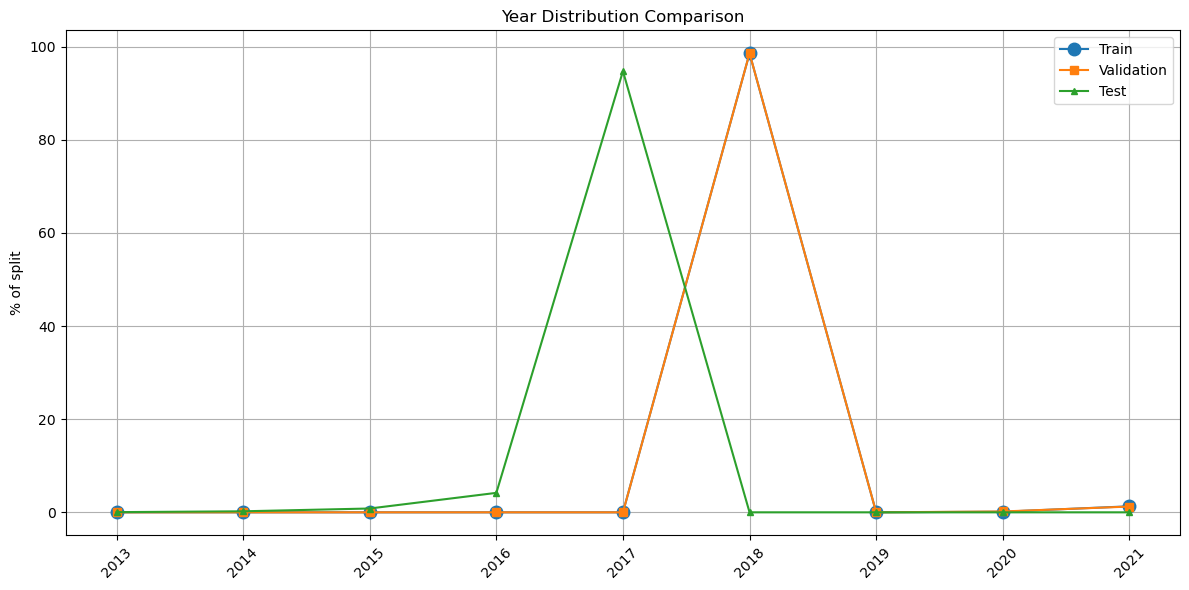

In [328]:
plot_compare_distribution(train_dist=train_month_dist, val_dist=val_month_dist, test_dist=test_month_dist, feature=sorted(list(full_data_df["Adv_year"].value_counts().index)), feature_name="Year")

### Miles
Train, Val: [17038, 79000]. Test: <= 17038 & > 79000

In [188]:
train_miles_df, val_miles_df, test_miles_df = create_shifted_splits(df=full_data_df, 
                                                                   split=[{"Runned_Miles": (">=", 17038.0)},
                                                                          {"Runned_Miles": ("<=", 79000.0)}],
                                                                   split_cond="and",
                                                                   ratio=ratio,
                                                                   mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_miles_df, val_miles_df, test_miles_df, cat_mapping = categorize(train_df=train_miles_df,
                                                                     val_df=val_miles_df,
                                                                     test_df=test_miles_df,
                                                                     categorical_columns=cat_plus_gen_cols)

train_miles_df, val_miles_df, test_miles_df, mean_price, std_price = normalize(train_df=train_miles_df,
                                                        val_df=val_miles_df,
                                                        test_df=test_miles_df,
                                                        continuous_columns=continuous_columns)

train_miles_df = reorder_df(df=train_miles_df, new_order=reorder_columns)
val_miles_df = reorder_df(df=val_miles_df, new_order=reorder_columns)
test_miles_df = reorder_df(df=test_miles_df, new_order=reorder_columns)

display(train_miles_df)
display(val_miles_df)
display(test_miles_df)

280
286
Shape of train df:	(29000, 21)
Shape of val df:	(4998, 21)
Shape of test df:	(4932, 21)
Total Size: 38930
Amount Classes: 278
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
12,0,0,0,0,0.035455,-1.400320,1.163536,-1.542789,11.926582,0.172302,...,8.078492,5.753999,2.121390,2.150554,2.041852,2.020290,225,Bentley$$Bentayga$$2016$$Black$$10_3$$69$$imag...,0,10_3$$69
16,1,0,0,0,0.035455,1.121713,1.163536,-0.602321,11.369647,0.172302,...,8.078492,5.753999,1.938667,1.723351,2.374225,2.063187,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$84$$image...,0,10_3$$84
19,2,0,0,0,0.035455,0.617307,1.163536,-0.705391,10.865271,0.172302,...,8.078492,5.753999,2.265354,1.936953,2.543669,1.920197,225,Bentley$$Bentayga$$2016$$Blue$$10_3$$96$$image...,0,10_3$$96
146,2,1,0,0,0.035455,1.121713,1.163536,-1.375821,10.056653,-1.067278,...,8.390137,3.003612,0.864476,-1.326880,2.608840,1.198098,45,Bentley$$Continental$$2016$$Blue$$10_5$$432$$i...,1,10_5$$432
147,3,1,0,0,0.035455,0.617307,1.163536,-1.352817,11.066415,-1.067278,...,8.390137,3.003612,0.964143,-1.284160,2.465464,1.202864,45,Bentley$$Continental$$2016$$Purple$$10_5$$537$...,1,10_5$$537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176303,2,6,2,1,0.035455,1.121713,-0.041114,0.286695,-0.323979,0.172302,...,0.015539,-0.296852,-0.076826,-0.754428,-0.956016,0.580859,0,Volvo$$V50$$2012$$Blue$$96_9$$503$$image_0.jpg,277,96_9$$503
176308,4,6,2,0,0.035455,1.121713,-0.643439,1.519094,-0.506019,0.172302,...,-0.116738,-0.296852,-0.060215,-0.950941,-0.375994,0.475999,0,Volvo$$V50$$2010$$Silver$$96_9$$110$$image_1.jpg,277,96_9$$110
176313,4,6,2,1,0.035455,1.121713,-0.643439,1.286839,-0.527144,0.172302,...,-0.116738,-0.296852,0.150194,-0.660443,-0.695332,0.540345,0,Volvo$$V50$$2010$$Silver$$96_9$$196$$image_0.jpg,277,96_9$$196
176352,4,6,0,0,0.035455,1.121713,-2.149251,1.509093,-0.678255,0.172302,...,-0.123663,0.803303,0.100360,-0.745884,-0.929948,0.588008,315,Volvo$$V50$$2005$$Silver$$96_9$$338$$image_0.jpg,277,96_9$$338


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
6,1,0,0,0,-2.944824,1.626120,1.163536,-1.475613,11.572306,0.172302,...,8.078492,5.753999,2.021723,2.124922,2.035335,1.927346,135,Bentley$$Bentayga$$2016$$Grey$$10_3$$41$$image...,0,10_3$$41
137,1,2,0,0,0.035455,-0.391506,1.163536,-1.319090,8.742144,-1.067278,...,8.390137,3.003612,0.947532,-1.079102,2.191746,1.126603,0,Bentley$$Continental$$2016$$Grey$$10_5$$143$$i...,1,10_5$$143
181,4,1,0,0,-2.944824,2.130526,-1.245764,-0.708003,3.992019,-1.067278,...,7.018899,5.753999,0.775883,-1.267072,1.390142,1.205248,45,Bentley$$Continental$$2008$$Silver$$10_5$$227$...,1,10_5$$227
214,0,1,0,0,0.035455,1.121713,-1.245764,-0.241158,3.789864,-1.067278,...,7.018899,5.753999,0.919846,-0.797148,1.351039,1.140902,180,Bentley$$Continental$$2008$$Black$$10_5$$676$$...,1,10_5$$676
223,0,1,0,0,-2.944824,-1.400320,-1.245764,0.967293,2.773533,-1.067278,...,7.018899,5.753999,0.582085,-1.062014,1.324971,1.283892,90,Bentley$$Continental$$2008$$Black$$10_5$$725$$...,1,10_5$$725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175971,0,6,0,1,0.035455,-0.391506,-1.546926,0.453386,-0.354808,0.172302,...,-0.233431,0.803303,0.155731,-0.369945,-0.995119,0.490298,0,Volvo$$V50$$2007$$Black$$96_9$$254$$image_1.jpg,277,96_9$$254
176122,4,6,2,1,0.035455,-0.391506,-0.342276,1.492424,-0.506424,0.172302,...,-0.106349,-0.296852,0.172342,-0.387033,-0.421614,0.638055,45,Volvo$$V50$$2011$$Silver$$96_9$$326$$image_0.jpg,277,96_9$$326
176125,6,6,2,1,0.035455,1.121713,-0.342276,1.397966,-0.354403,0.172302,...,-0.106349,0.253225,-0.115585,-1.036382,-0.389028,0.635671,270,Volvo$$V50$$2011$$Red$$96_9$$339$$image_0.jpg,277,96_9$$339
176193,2,6,2,1,-2.944824,1.121713,-1.245764,0.120005,-0.455885,0.172302,...,-0.233431,0.253225,-0.115585,-0.660443,-0.734435,0.452168,315,Volvo$$V50$$2008$$Blue$$96_9$$208$$image_1.jpg,277,96_9$$208


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
0,1,0,0,0,0.035455,-1.400320,1.163536,-1.843554,12.077187,0.172302,...,8.078492,5.753999,1.994037,1.842968,2.028818,1.972626,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,0,10_3$$1
38,7,0,0,1,0.035455,-0.895913,1.765861,-2.435917,16.116234,0.172302,...,8.078492,3.003612,2.237668,2.142010,2.511084,2.027439,90,Bentley$$Bentayga$$2018$$Green$$10_3$$26$$imag...,0,10_3$$26
41,0,0,0,0,0.035455,0.617307,1.765861,-2.463921,17.632392,0.172302,...,8.078492,5.753999,1.971889,2.099290,2.211297,1.910664,90,Bentley$$Bentayga$$2018$$Black$$10_3$$29$$imag...,0,10_3$$29
58,1,0,0,0,0.035455,-0.895913,1.765861,-2.516484,15.615901,0.172302,...,8.078492,3.003612,2.254280,1.817336,2.550186,1.896365,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$82$$image...,0,10_3$$82
104,1,0,0,1,0.035455,1.121713,1.464698,-1.963627,11.774966,0.172302,...,8.078492,3.003612,2.276428,1.979673,2.413327,2.067953,225,Bentley$$Bentayga$$2017$$Grey$$10_3$$110$$imag...,0,10_3$$110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176335,2,6,2,0,0.035455,0.112900,-2.149251,4.342832,-1.031520,0.172302,...,-0.123663,-0.021813,-0.076826,-1.002206,-0.995119,0.599924,45,Volvo$$V50$$2005$$Blue$$96_9$$68$$image_0.jpg,277,96_9$$68
176342,2,6,2,1,0.035455,1.121713,-2.149251,3.842761,-0.814204,0.172302,...,-0.123663,0.253225,0.222176,-0.643355,-0.682298,0.638055,0,Volvo$$V50$$2005$$Blue$$96_9$$189$$image_0.jpg,277,96_9$$189
176350,2,6,2,1,0.035455,-0.391506,-2.149251,4.731777,-0.834419,0.172302,...,-0.123663,0.253225,0.244324,-0.814236,-1.001636,0.530812,45,Volvo$$V50$$2005$$Blue$$96_9$$317$$image_0.jpg,277,96_9$$317
176378,4,6,2,1,0.035455,0.112900,-1.848089,2.620363,-0.759117,0.172302,...,-0.233431,0.253225,-0.093437,-0.369945,-0.838709,0.604690,90,Volvo$$V50$$2006$$Silver$$96_9$$156$$image_0.jpg,277,96_9$$156


In [189]:
print(get_num_of_classes(df_list=[train_miles_df]))
print(get_num_of_classes(df_list=[val_miles_df]))
print(get_num_of_classes(df_list=[test_miles_df]))

278
278
278


In [190]:
miles_lengths = get_lengths(df_list=[train_miles_df, val_miles_df, test_miles_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [191]:
k = 0.1
low_train_miles_df, high_train_miles_df = create_splitted_train(train_df=train_miles_df, low_data_split=k, nclasses=train_miles_df["Genmodel_ID"].nunique())
display(low_train_miles_df)
display(high_train_miles_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
12,0,0,0,0,0.035455,-1.400320,1.163536,-1.542789,11.926582,0.172302,...,8.078492,5.753999,2.121390,2.150554,2.041852,2.020290,225,Bentley$$Bentayga$$2016$$Black$$10_3$$69$$imag...,0,10_3$$69
146,2,1,0,0,0.035455,1.121713,1.163536,-1.375821,10.056653,-1.067278,...,8.390137,3.003612,0.864476,-1.326880,2.608840,1.198098,45,Bentley$$Continental$$2016$$Blue$$10_5$$432$$i...,1,10_5$$432
185,2,2,0,0,-2.944824,2.130526,-1.245764,0.508949,2.069024,-1.067278,...,7.018899,5.753999,1.667350,-0.839868,1.298902,2.225242,0,Bentley$$Continental$$2008$$Blue$$10_5$$262$$i...,1,10_5$$262
217,2,1,0,0,0.035455,-0.895913,-1.245764,-0.213376,3.991514,-1.067278,...,7.018899,5.753999,0.903235,-1.198719,1.800719,1.181416,0,Bentley$$Continental$$2008$$Blue$$10_5$$685$$i...,1,10_5$$685
275,0,2,0,0,-2.944824,3.139340,0.561211,-1.157956,7.327062,-1.067278,...,7.676816,3.003612,0.532252,-1.480673,2.328605,1.298191,45,Bentley$$Continental$$2014$$Black$$10_5$$486$$...,1,10_5$$486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175713,2,4,2,1,0.035455,-0.391506,0.862373,0.281028,-0.081495,0.172302,...,-0.014587,-0.296852,0.399362,-0.968029,1.292385,0.159039,0,Volvo$$V40$$2015$$Blue$$96_7$$9$$image_0.jpg,276,96_7$$9
175968,2,6,2,8,0.035455,0.617307,-1.546926,-0.177871,-0.405346,0.172302,...,-0.233431,-0.021813,0.083749,-0.549370,-0.956016,0.540345,90,Volvo$$V50$$2007$$Blue$$96_9$$222$$image_1.jpg,277,96_9$$222
176038,0,6,2,1,0.035455,-1.400320,-0.944601,1.842474,-0.506424,0.172302,...,-0.234124,0.253225,0.338454,-0.335768,-0.349926,0.645204,270,Volvo$$V50$$2009$$Black$$96_9$$270$$image_0.jpg,277,96_9$$270
176124,1,6,0,1,0.035455,1.121713,-0.342276,-1.145454,-0.102620,0.172302,...,-0.106349,0.253225,0.244324,-0.788604,-0.708366,0.635671,0,Volvo$$V50$$2011$$Grey$$96_9$$333$$image_22.jpg,277,96_9$$333


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
16,1,0,0,0,0.035455,1.121713,1.163536,-0.602321,11.369647,0.172302,...,8.078492,5.753999,1.938667,1.723351,2.374225,2.063187,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$84$$image...,0,10_3$$84
19,2,0,0,0,0.035455,0.617307,1.163536,-0.705391,10.865271,0.172302,...,8.078492,5.753999,2.265354,1.936953,2.543669,1.920197,225,Bentley$$Bentayga$$2016$$Blue$$10_3$$96$$image...,0,10_3$$96
147,3,1,0,0,0.035455,0.617307,1.163536,-1.352817,11.066415,-1.067278,...,8.390137,3.003612,0.964143,-1.284160,2.465464,1.202864,45,Bentley$$Continental$$2016$$Purple$$10_5$$537$...,1,10_5$$537
161,0,2,0,0,0.035455,-0.895913,-1.245764,0.114393,2.670434,-1.067278,...,7.018899,5.753999,0.515640,-1.318336,1.722514,1.300574,0,Bentley$$Continental$$2008$$Black$$10_5$$8$$im...,1,10_5$$8
163,2,1,0,0,0.035455,-0.391506,-1.245764,-0.303056,4.497405,-1.067278,...,7.018899,5.753999,0.703901,-1.600290,0.236614,1.310107,0,Bentley$$Continental$$2008$$Blue$$10_5$$61$$im...,1,10_5$$61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176303,2,6,2,1,0.035455,1.121713,-0.041114,0.286695,-0.323979,0.172302,...,0.015539,-0.296852,-0.076826,-0.754428,-0.956016,0.580859,0,Volvo$$V50$$2012$$Blue$$96_9$$503$$image_0.jpg,277,96_9$$503
176308,4,6,2,0,0.035455,1.121713,-0.643439,1.519094,-0.506019,0.172302,...,-0.116738,-0.296852,-0.060215,-0.950941,-0.375994,0.475999,0,Volvo$$V50$$2010$$Silver$$96_9$$110$$image_1.jpg,277,96_9$$110
176313,4,6,2,1,0.035455,1.121713,-0.643439,1.286839,-0.527144,0.172302,...,-0.116738,-0.296852,0.150194,-0.660443,-0.695332,0.540345,0,Volvo$$V50$$2010$$Silver$$96_9$$196$$image_0.jpg,277,96_9$$196
176352,4,6,0,0,0.035455,1.121713,-2.149251,1.509093,-0.678255,0.172302,...,-0.123663,0.803303,0.100360,-0.745884,-0.929948,0.588008,315,Volvo$$V50$$2005$$Silver$$96_9$$338$$image_0.jpg,277,96_9$$338


In [192]:
print(get_num_of_classes(df_list=[low_train_miles_df]))
print(get_num_of_classes(df_list=[high_train_miles_df]))
print(get_num_of_classes(df_list=[val_miles_df]))

278
275
278


In [193]:
miles_dir = os.path.join(SHIFTED_DIR, "miles")

In [194]:
save_lengths(lengths=miles_lengths, file_name="tabular_lengths.pt", save_directory=miles_dir)

In [195]:
save_dataset(df=train_miles_df, save_directory=miles_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_miles_df, save_directory=miles_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_miles_df, save_directory=miles_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_miles_df, save_directory=miles_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_miles_df, save_directory=miles_dir, split="test", k="", keep_cols=reorder_columns)

In [196]:
k = 0.01
low_train_miles_df, high_train_miles_df = create_splitted_train(train_df=train_miles_df, low_data_split=k, nclasses=train_miles_df["Genmodel_ID"].nunique())
display(low_train_miles_df)
display(high_train_miles_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
12,0,0,0,0,0.035455,-1.400320,1.163536,-1.542789,11.926582,0.172302,...,8.078492,5.753999,2.121390,2.150554,2.041852,2.020290,225,Bentley$$Bentayga$$2016$$Black$$10_3$$69$$imag...,0,10_3$$69
146,2,1,0,0,0.035455,1.121713,1.163536,-1.375821,10.056653,-1.067278,...,8.390137,3.003612,0.864476,-1.326880,2.608840,1.198098,45,Bentley$$Continental$$2016$$Blue$$10_5$$432$$i...,1,10_5$$432
822,4,4,2,0,0.035455,0.617307,-0.342276,-1.255248,-0.710600,0.172302,...,-0.849104,-1.121968,-1.394648,0.117067,-1.940099,-1.568755,45,Chevrolet$$Spark$$2011$$Silver$$16_14$$30$$ima...,2,16_14$$30
998,6,5,2,1,0.035455,-0.895913,0.862373,-0.880138,-0.354808,0.172302,...,-0.434269,-0.296852,-0.248475,0.774960,-0.636678,-0.448668,45,Citroen$$C3 Picasso$$2015$$Red$$18_10$$5$$imag...,3,18_10$$5
1454,1,4,2,1,0.035455,1.121713,0.260049,-0.770178,-0.394026,0.172302,...,-0.369516,-0.296852,0.100360,-0.515194,-0.408580,0.037497,225,Citroen$$C4$$2013$$Grey$$18_12$$9$$image_1.jpg,4,18_12$$9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174817,6,3,0,1,0.035455,-0.391506,-0.342276,-0.480359,-0.152653,0.172302,...,0.182442,0.253225,0.936457,-0.703163,-0.134861,-0.753713,0,Volvo$$S60$$2011$$Red$$96_4$$6$$image_0.jpg,273,96_4$$6
175244,2,3,0,1,0.035455,0.617307,-1.245764,1.509093,-0.456390,0.172302,...,0.282515,0.803303,1.008439,-0.156343,1.214180,1.281509,45,Volvo$$S80$$2008$$Blue$$96_5$$60$$image_0.jpg,274,96_5$$60
175431,1,3,0,1,0.035455,0.617307,1.464698,-1.115450,1.463066,0.172302,...,0.952205,0.253225,1.910981,-0.634811,1.090355,1.634217,225,Volvo$$S90$$2017$$Grey$$96_6$$102$$image_0.jpg,275,96_6$$102
175478,6,4,2,1,-2.944824,1.626120,0.260049,1.786910,-0.227956,0.172302,...,-0.014587,-0.296852,0.349528,-0.557914,1.409693,0.166188,135,Volvo$$V40$$2013$$Red$$96_7$$60$$image_2.jpg,276,96_7$$60


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Predicted_viewpoint,Image_name,Genmodel_ID,Adv_ID
16,1,0,0,0,0.035455,1.121713,1.163536,-0.602321,11.369647,0.172302,...,8.078492,5.753999,1.938667,1.723351,2.374225,2.063187,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$84$$image...,0,10_3$$84
19,2,0,0,0,0.035455,0.617307,1.163536,-0.705391,10.865271,0.172302,...,8.078492,5.753999,2.265354,1.936953,2.543669,1.920197,225,Bentley$$Bentayga$$2016$$Blue$$10_3$$96$$image...,0,10_3$$96
147,3,1,0,0,0.035455,0.617307,1.163536,-1.352817,11.066415,-1.067278,...,8.390137,3.003612,0.964143,-1.284160,2.465464,1.202864,45,Bentley$$Continental$$2016$$Purple$$10_5$$537$...,1,10_5$$537
161,0,2,0,0,0.035455,-0.895913,-1.245764,0.114393,2.670434,-1.067278,...,7.018899,5.753999,0.515640,-1.318336,1.722514,1.300574,0,Bentley$$Continental$$2008$$Black$$10_5$$8$$im...,1,10_5$$8
163,2,1,0,0,0.035455,-0.391506,-1.245764,-0.303056,4.497405,-1.067278,...,7.018899,5.753999,0.703901,-1.600290,0.236614,1.310107,0,Bentley$$Continental$$2008$$Blue$$10_5$$61$$im...,1,10_5$$61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176303,2,6,2,1,0.035455,1.121713,-0.041114,0.286695,-0.323979,0.172302,...,0.015539,-0.296852,-0.076826,-0.754428,-0.956016,0.580859,0,Volvo$$V50$$2012$$Blue$$96_9$$503$$image_0.jpg,277,96_9$$503
176308,4,6,2,0,0.035455,1.121713,-0.643439,1.519094,-0.506019,0.172302,...,-0.116738,-0.296852,-0.060215,-0.950941,-0.375994,0.475999,0,Volvo$$V50$$2010$$Silver$$96_9$$110$$image_1.jpg,277,96_9$$110
176313,4,6,2,1,0.035455,1.121713,-0.643439,1.286839,-0.527144,0.172302,...,-0.116738,-0.296852,0.150194,-0.660443,-0.695332,0.540345,0,Volvo$$V50$$2010$$Silver$$96_9$$196$$image_0.jpg,277,96_9$$196
176352,4,6,0,0,0.035455,1.121713,-2.149251,1.509093,-0.678255,0.172302,...,-0.123663,0.803303,0.100360,-0.745884,-0.929948,0.588008,315,Volvo$$V50$$2005$$Silver$$96_9$$338$$image_0.jpg,277,96_9$$338


In [197]:
print(get_num_of_classes(df_list=[low_train_miles_df]))
print(get_num_of_classes(df_list=[high_train_miles_df]))
print(get_num_of_classes(df_list=[val_miles_df]))

278
275
278


In [198]:
save_dataset(df=low_train_miles_df, save_directory=miles_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_miles_df, save_directory=miles_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

In [199]:
train_miles_denorm_df = denormalize_column(df=train_miles_df, column="Runned_Miles", means=mean_price, stds=std_price)
val_miles_denorm_df = denormalize_column(df=val_miles_df, column="Runned_Miles", means=mean_price, stds=std_price)
test_miles_denorm_df = denormalize_column(df=test_miles_df, column="Runned_Miles", means=mean_price, stds=std_price)
train_miles_denorm_df

0        18074.0
1        35000.0
2        33145.0
3        21079.0
4        21493.0
          ...   
28995    51000.0
28996    73180.0
28997    69000.0
28998    73000.0
28999    75000.0
Name: Runned_Miles, Length: 29000, dtype: float64

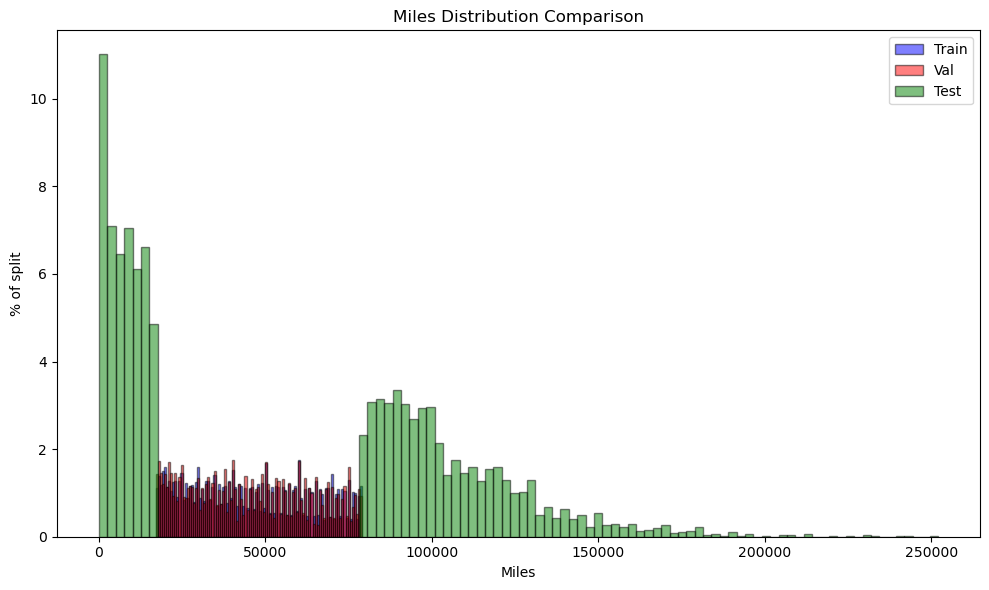

In [200]:
plot_histogram_comparison(train=train_miles_denorm_df, val=val_miles_denorm_df, test=test_miles_denorm_df, feature="Miles", bins=100)

## Get smaller set of original dataset

In [201]:
_ids = list(full_data_df['Adv_ID'])
ratio = [29000, 5000, 5000]
small_train_ids, small_test_ids = train_test_split(_ids, train_size=ratio[0]+ratio[1], test_size=ratio[2], random_state=2022, stratify=full_data_df['Genmodel_ID'])
small_train_ids, small_val_ids = train_test_split(small_train_ids, test_size=ratio[1], random_state=2022, stratify=full_data_df[full_data_df['Adv_ID'].isin(small_train_ids)]['Genmodel_ID'])

small_train_df = full_data_df.set_index('Adv_ID').loc[small_train_ids]
small_val_df = full_data_df.set_index('Adv_ID').loc[small_val_ids]
small_test_df = full_data_df.set_index('Adv_ID').loc[small_test_ids]

print(len(small_train_df))
print(len(small_val_df))
print(len(small_test_df))

29000
5000
5000


In [202]:
cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
small_train_df, small_val_df, small_test_df, cat = categorize(train_df=small_train_df,
                                                                     val_df=small_val_df,
                                                                     test_df=small_test_df,
                                                                     categorical_columns=cat_plus_gen_cols)

small_train_df, small_val_df, small_test_df, mean_small, std_small = normalize(train_df=small_train_df,
                                                        val_df=small_val_df,
                                                        test_df=small_test_df,
                                                        continuous_columns=continuous_columns)

small_train_df = reorder_df(df=small_train_df, new_order=reorder_columns).reset_index()
small_val_df = reorder_df(df=small_val_df, new_order=reorder_columns).reset_index()
small_test_df = reorder_df(df=small_test_df, new_order=reorder_columns).reset_index()

In [203]:
get_num_of_classes(df_list=[small_train_df, small_val_df])

286

In [204]:
print(len(small_train_df))
print(len(small_val_df))
print(len(small_test_df))

29000
5000
5000


In [205]:
xtick_small_map = {v: k for k, v in cat["Color"].items()}

In [206]:
small_lengths = get_lengths(df_list=[small_train_df, small_val_df, small_test_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [207]:
train_small_dist = create_dist_dfs(df=small_train_df,
                                    cols=["Color"],
                                    fill_values=list(range(small_lengths["Color"]+1)))
val_small_dist = create_dist_dfs(df=small_val_df,
                                    cols=["Color"],
                                    fill_values=list(range(small_lengths["Color"]+1)))
test_small_dist = create_dist_dfs(df=small_test_df,
                                    cols=["Color"],
                                    fill_values=list(range(small_lengths["Color"]+1)))

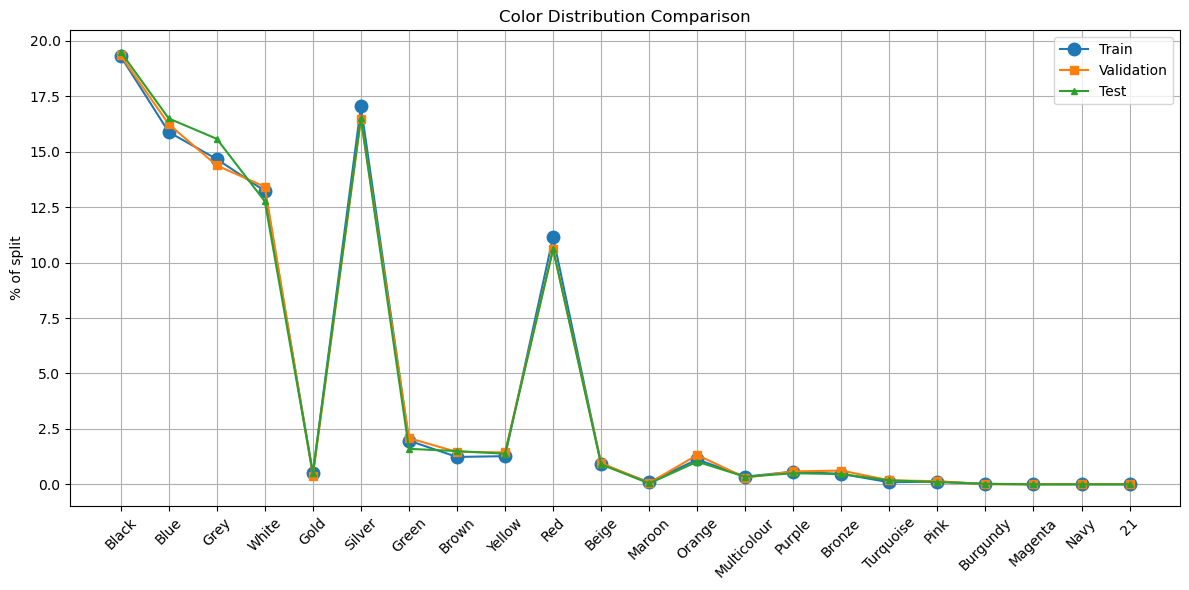

In [208]:
plot_compare_distribution(train_dist=train_small_dist, val_dist=val_small_dist, test_dist=test_small_dist, feature=list(range(int(small_lengths["Color"]) + 1)), feature_name="Color", xticks_map=xtick_small_map)

In [209]:
k = 0.1
small_low_train_miles_df, small_high_train_miles_df = create_splitted_train(train_df=small_train_df, low_data_split=k, nclasses=small_train_df["Genmodel_ID"].nunique())

display(len(small_low_train_miles_df))
display(len(small_high_train_miles_df))

2900

26100

In [210]:
k = 0.01
small_very_low_train_miles_df, small_very_high_train_miles_df = create_splitted_train(train_df=small_train_df, low_data_split=k, nclasses=small_train_df["Genmodel_ID"].nunique())
display(len(small_very_low_train_miles_df))
display(len(small_very_high_train_miles_df))

290

28710

In [211]:
normal_dir = os.path.join(SHIFTED_DIR, "normal")

In [212]:
save_lengths(lengths=small_lengths, file_name="tabular_lengths.pt", save_directory=normal_dir)

save_dataset(df=small_train_df, save_directory=normal_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=small_low_train_miles_df, save_directory=normal_dir, split="train", k="_0.1", keep_cols=reorder_columns)
save_dataset(df=small_very_low_train_miles_df, save_directory=normal_dir, split="train", k="_0.01", keep_cols=reorder_columns)

save_dataset(df=small_val_df, save_directory=normal_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=small_test_df, save_directory=normal_dir, split="test", k="", keep_cols=reorder_columns)

save_dataset(df=small_high_train_miles_df, save_directory=normal_dir, split="train", k="_0.9", keep_cols=reorder_columns)
save_dataset(df=small_very_high_train_miles_df, save_directory=normal_dir, split="train", k="_0.99", keep_cols=reorder_columns)

In [213]:
def compare_label_dist(path1: str, path2: str, title1: str, title2: str, plot_title: str = "") -> None:    
    label_data_first = torch.load(path1, map_location='cpu')
    print(len(label_data_first))

    label_data_second = torch.load(path2, map_location='cpu')
    print(len(label_data_second))

    from collections import Counter
    label_counts_first = Counter(label_data_first)
    label_counts_second = Counter(label_data_second)
    
    print(len(set(label_counts_first.keys())))
    print(len(set(label_counts_second.keys())))

    # Get sorted list of all label IDs (for alignment)
    all_labels = sorted(set(label_counts_first.keys()) | set(label_counts_second.keys()))

    # Create aligned frequency arrays
    label_freqs_first = np.array([label_counts_first.get(l, 0) for l in all_labels])
    label_freqs_second = np.array([label_counts_second.get(l, 0) for l in all_labels])

    label_freqs_norm_first = label_freqs_first / label_freqs_first.sum()
    label_freqs_norm_second = label_freqs_second / label_freqs_second.sum()

    print(f"Jensen-Shannon Divergence: {jensenshannon(label_freqs_norm_first, label_freqs_norm_second)}")
    print(f"KL-Divergence: {sum(kl_div(label_freqs_norm_first, label_freqs_norm_second))}")
    plot_title = ": " + plot_title + " " + title1 + " vs " + title2 if len(plot_title) > 0 else plot_title

    plt.figure(figsize=(18, 6))
    plt.plot(all_labels, label_freqs_norm_first, label=title1, marker='o')
    plt.plot(all_labels, label_freqs_norm_second, label=title2, marker='x')
    plt.title(f"Label Distribution{plot_title}")
    plt.xlabel("Label ID")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

288
4977
281
281
Jensen-Shannon Divergence: 0.2639949066046392
KL-Divergence: 0.29259907568097027


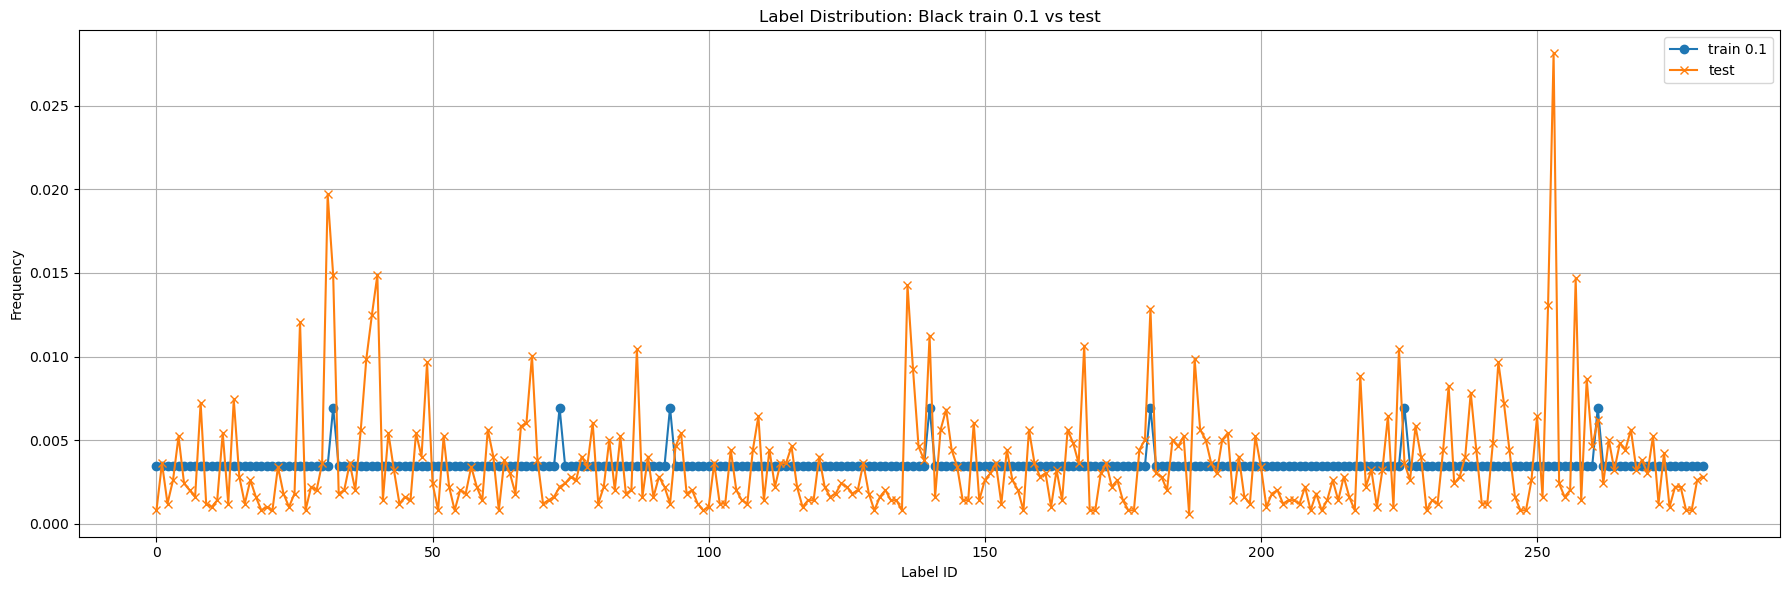

In [226]:
compare_label_dist(path1=os.path.join(SHIFTED_DIR, "Adv_year", "labels_train_0.01.pt"), path2=os.path.join(SHIFTED_DIR, "Adv_year", "labels_val.pt"), title1="train 0.1", title2="test", plot_title="Black")

## Create distorted label distribution shift

In [215]:
ratio = [5286, 0, 0]
test_label_df, _, _ = create_shifted_splits(df=full_data_df,
                                                split=[{"Color": "Black"},
                                                       {"Color": "Grey"},
                                                       {"Color": "White"}],
                                                split_cond="or",
                                                ratio=ratio,
                                                mode=0)

train_label_w_g_df = create_cutted_split(df=full_data_df[full_data_df["Color"].isin(["Grey", "White"])], desired_size=30600)

train_label_black = create_cutted_split(df=full_data_df[full_data_df["Color"].isin(["Black"])], desired_size=3400)

train_label_df = pd.concat([train_label_w_g_df, train_label_black])

train_labelled_df_01 = create_cutted_split(df=train_label_df[train_label_df["Color"].isin(["Black"])], desired_size=2900)

train_labelled_df_001 = create_cutted_split(df=train_label_df[train_label_df["Color"].isin(["Black"])], desired_size=290)

train_unlabelled_df_01 = create_cutted_split(df=train_label_df[train_label_df["Color"].isin(["Grey", "White"])], desired_size=26100)

train_unlabelled_df_001 = create_cutted_split(df=train_label_df[train_label_df["Color"].isin(["Grey", "White"])], desired_size=28710)


train_rest_01 = train_label_df[~train_label_df["Adv_ID"].isin(pd.concat([train_labelled_df_01, train_unlabelled_df_01])["Adv_ID"])]
train_rest_001 = train_label_df[~train_label_df["Adv_ID"].isin(pd.concat([train_labelled_df_001, train_unlabelled_df_001])["Adv_ID"])]

val_label_df_01 = create_cutted_split(df=train_rest_01, desired_size=5000)
val_label_df_001 = create_cutted_split(df=train_rest_001, desired_size=5000)

286
286
Shape of train df:	(5000, 21)
Shape of val df:	(286, 21)
Shape of test df:	(286, 21)
Total Size: 5572
Amount Classes: 286
Ratio -> Train: 0.9 | Val: 0.05 | Test: 0.05
Too little data.
Too little data.


In [216]:
train_labelled_df_01_label = list(train_labelled_df_01["Adv_ID"])
train_01_df, val_01_df, test_01_df, cat_mapping = categorize(train_df=pd.concat([train_labelled_df_01, train_unlabelled_df_01]),
                                                                     val_df=val_label_df_01,
                                                                     test_df=test_label_df,
                                                                     categorical_columns=cat_plus_gen_cols)


train_01_df, val_01_df, test_01_df, mean_price, std_price = normalize(train_df=train_01_df,
                                                        val_df=val_01_df,
                                                        test_df=test_01_df,
                                                        continuous_columns=continuous_columns)

train_la_01_df = train_01_df[train_01_df["Adv_ID"].isin(train_labelled_df_01_label)]
train_unla_01_df = train_01_df[~train_01_df["Adv_ID"].isin(train_labelled_df_01_label)]

train_la_01_df, train_unla_01_df, val_01_df, test_01_df = ensure_same_class_num(df_list=[train_la_01_df, train_unla_01_df, val_01_df, test_01_df])

In [217]:
train_labelled_df_001_label = list(train_labelled_df_001["Adv_ID"])
train_001_df, val_001_df, test_001_df, cat_mapping = categorize(train_df=pd.concat([train_labelled_df_001, train_unlabelled_df_001]),
                                                                     val_df=val_label_df_001,
                                                                     test_df=test_label_df,
                                                                     categorical_columns=cat_plus_gen_cols)

train_001_df, val_001_df, test_001_df, mean_price, std_price = normalize(train_df=train_001_df,
                                                        val_df=val_001_df,
                                                        test_df=test_001_df,
                                                        continuous_columns=continuous_columns)


train_la_001_df = train_001_df[train_001_df["Adv_ID"].isin(train_labelled_df_001_label)]
train_unla_001_df = train_001_df[~train_001_df["Adv_ID"].isin(train_labelled_df_001_label)]

train_la_001_df, train_unla_001_df, val_001_df, test_001_df = ensure_same_class_num(df_list=[train_la_001_df, train_unla_001_df, val_001_df, test_001_df])

In [218]:
print(len(train_la_001_df))
print(len(train_unla_001_df))
print(len(val_001_df))
print(len(test_001_df))
print(train_la_001_df["Color"].unique())
print(train_unla_001_df["Color"].unique())
print(val_001_df["Color"].unique())
print(test_001_df["Color"].unique())

all_years = pd.concat([df["Adv_ID"] for df in [train_la_001_df, train_unla_001_df, val_001_df, test_001_df]])
dupes = all_years[all_years.duplicated()]
print("✅ No duplicates." if dupes.empty else f"❌ Duplicates found: {dupes.unique()}")

print(len(train_la_01_df))
print(len(train_unla_01_df))
print(len(val_01_df))
print(len(test_01_df))
print(train_la_01_df["Color"].unique())
print(train_unla_01_df["Color"].unique())
print(val_01_df["Color"].unique())
print(test_01_df["Color"].unique())
all_years = pd.concat([df["Adv_ID"] for df in [train_la_01_df, train_unla_01_df, val_01_df, test_01_df]])
dupes = all_years[all_years.duplicated()]
print("✅ No duplicates." if dupes.empty else f"❌ Duplicates found: {dupes.unique()}")

288
28705
4998
4990
[0]
[1 2]
[2 0 1]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
✅ No duplicates.
2897
26100
5000
4995
[0]
[1 2]
[1 2 0]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
✅ No duplicates.


In [219]:
train_la_01_df = reorder_df(df=train_la_01_df, new_order=reorder_columns).reset_index()
train_unla_01_df = reorder_df(df=train_unla_01_df, new_order=reorder_columns).reset_index()
train_la_001_df = reorder_df(df=train_la_001_df, new_order=reorder_columns).reset_index()
train_unla_001_df = reorder_df(df=train_unla_001_df, new_order=reorder_columns).reset_index()

val_01_df = reorder_df(df=val_01_df, new_order=reorder_columns).reset_index()
val_001_df = reorder_df(df=val_001_df, new_order=reorder_columns).reset_index()

test_01_df = reorder_df(df=test_01_df, new_order=reorder_columns).reset_index()
test_001_df = reorder_df(df=test_001_df, new_order=reorder_columns).reset_index()

In [220]:
print(get_num_of_classes(df_list=[train_la_01_df]))
print(get_num_of_classes(df_list=[train_unla_01_df]))
print(get_num_of_classes(df_list=[val_01_df]))
print(get_num_of_classes(df_list=[test_01_df]))

285
285
285
285


In [221]:
print(get_num_of_classes(df_list=[train_la_001_df]))
print(get_num_of_classes(df_list=[train_unla_001_df]))
print(get_num_of_classes(df_list=[val_001_df]))
print(get_num_of_classes(df_list=[test_001_df]))

284
284
284
284


In [222]:
label_dir = os.path.join(SHIFTED_DIR, "label")

In [223]:
label_01_lengths = get_lengths(df_list=[train_la_01_df, train_unla_01_df, val_01_df, test_01_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [224]:
label_001_lengths = get_lengths(df_list=[train_la_001_df, train_unla_001_df, val_001_df, test_001_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [225]:
save_lengths(lengths=label_01_lengths, file_name="tabular_lengths_0.1.pt", save_directory=label_dir)
save_lengths(lengths=label_001_lengths, file_name="tabular_lengths_0.01.pt", save_directory=label_dir)

save_dataset(df=pd.concat([train_la_01_df, train_unla_01_df]), save_directory=label_dir, split="train", k="complete_0.1", keep_cols=reorder_columns)
save_dataset(df=train_la_01_df, save_directory=label_dir, split="train", k="_0.1", keep_cols=reorder_columns)
save_dataset(df=train_unla_01_df, save_directory=label_dir, split="train", k="_0.9", keep_cols=reorder_columns)

save_dataset(df=pd.concat([train_la_001_df, train_unla_001_df]), save_directory=label_dir, split="train", k="complete_0.01", keep_cols=reorder_columns)
save_dataset(df=train_la_001_df, save_directory=label_dir, split="train", k="_0.01", keep_cols=reorder_columns)
save_dataset(df=train_unla_001_df, save_directory=label_dir, split="train", k="_0.99", keep_cols=reorder_columns)

save_dataset(df=val_01_df, save_directory=label_dir, split="val", k="_0.1", keep_cols=reorder_columns)
save_dataset(df=val_001_df, save_directory=label_dir, split="val", k="_0.01", keep_cols=reorder_columns)

save_dataset(df=test_01_df, save_directory=label_dir, split="test", k="_0.1", keep_cols=reorder_columns)
save_dataset(df=test_001_df, save_directory=label_dir, split="test", k="_0.01", keep_cols=reorder_columns)